In [1]:
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, Normalizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.svm import SVR
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow import keras
from tensorflow.keras import layers
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

成功載入 Plant_1_Generation_Data.csv 和 Plant_1_Weather_Sensor_Data.csv。

--- Plant 1 探索性資料分析 ---


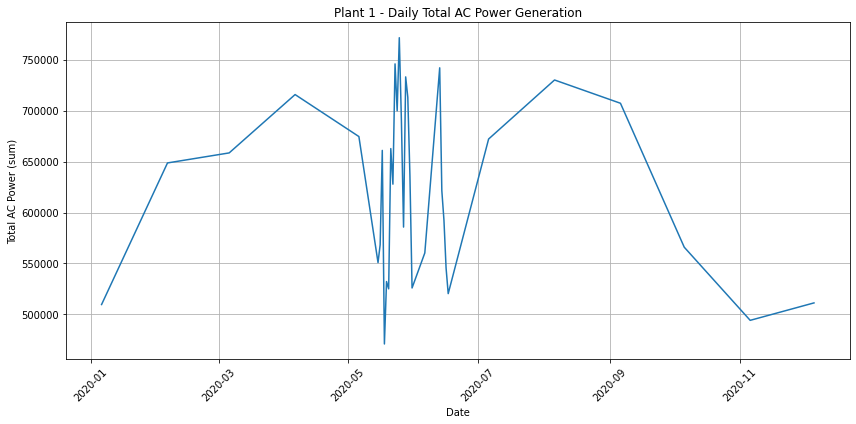

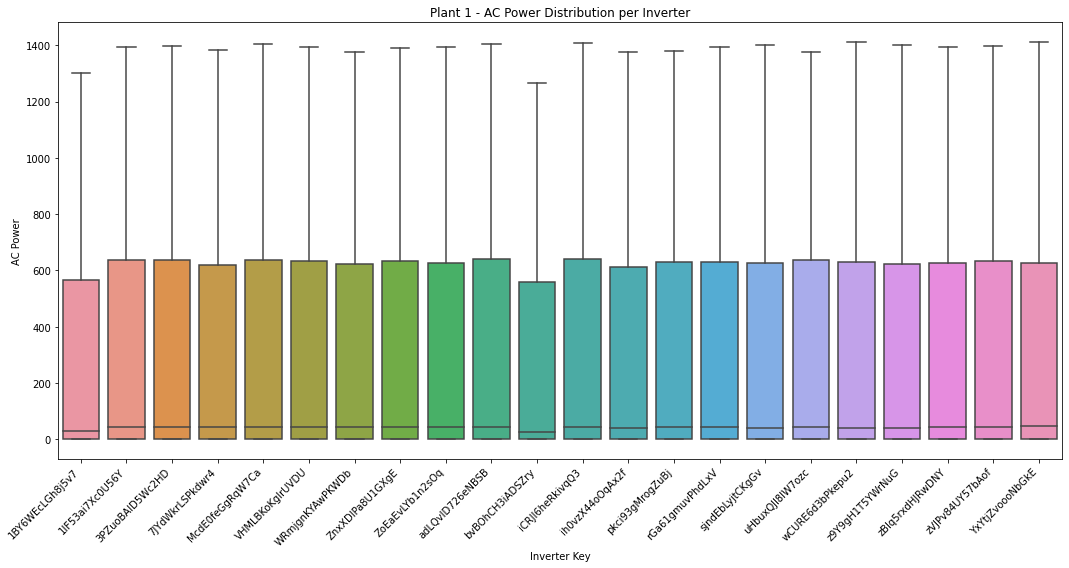

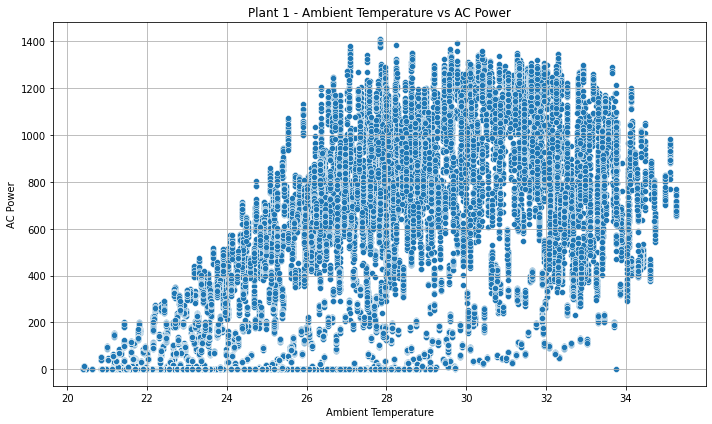

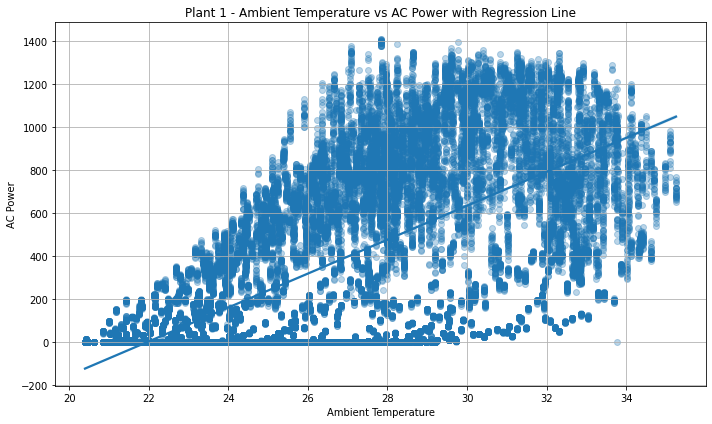


Plant 1 - Irradiance 最高的幾天：
DATE_TIME
2020-05-21    0.346414
2020-05-29    0.313869
2020-05-23    0.290074
2020-05-25    0.283681
2020-05-28    0.271171
Name: IRRADIATION, dtype: float64

Plant 1 - 日期: 2020-05-21, 平均 Irradiance: 0.35, 總發電量: 662742.45


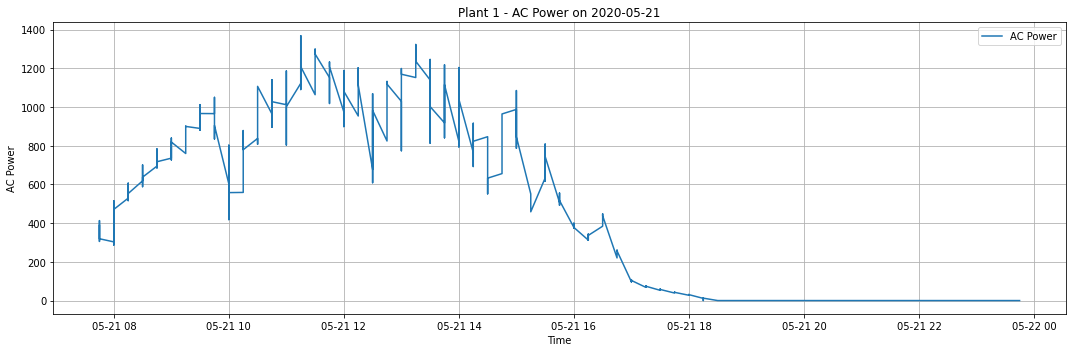

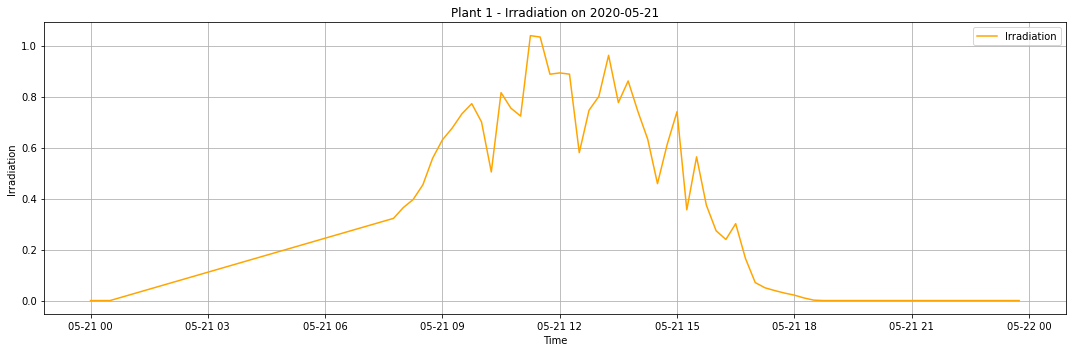


Plant 1 - 日期: 2020-05-29, 平均 Irradiance: 0.31, 總發電量: 713110.63


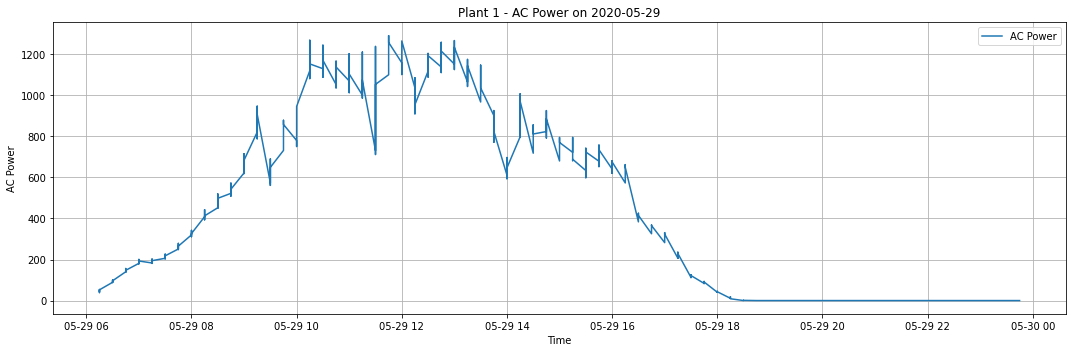

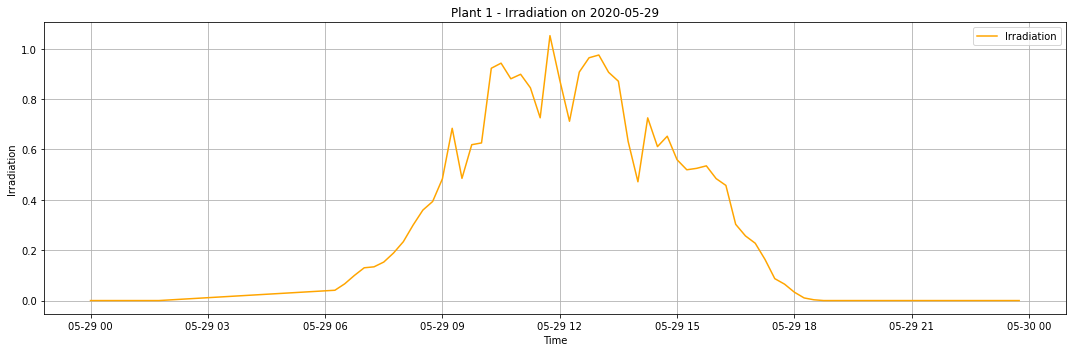


Plant 1 - 日期: 2020-05-23, 平均 Irradiance: 0.29, 總發電量: 745884.29


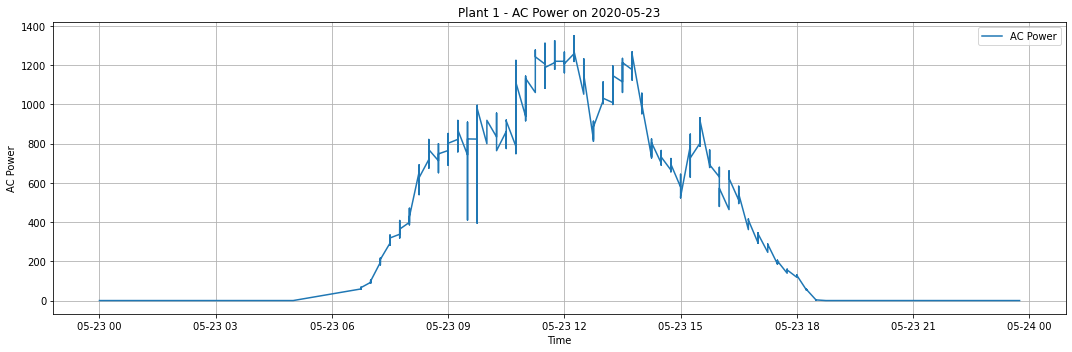

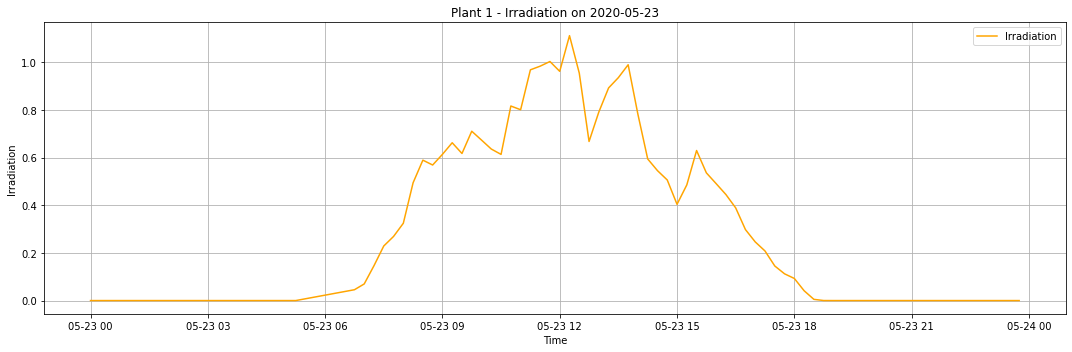


Plant 1 - 日期: 2020-05-25, 平均 Irradiance: 0.28, 總發電量: 771576.16


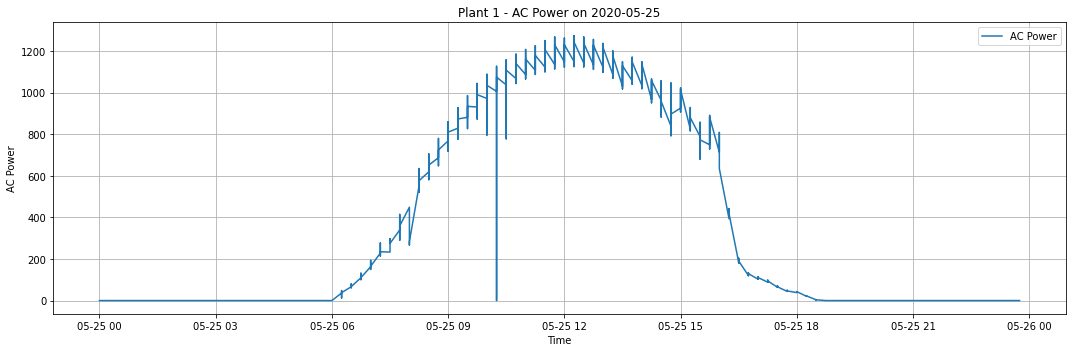

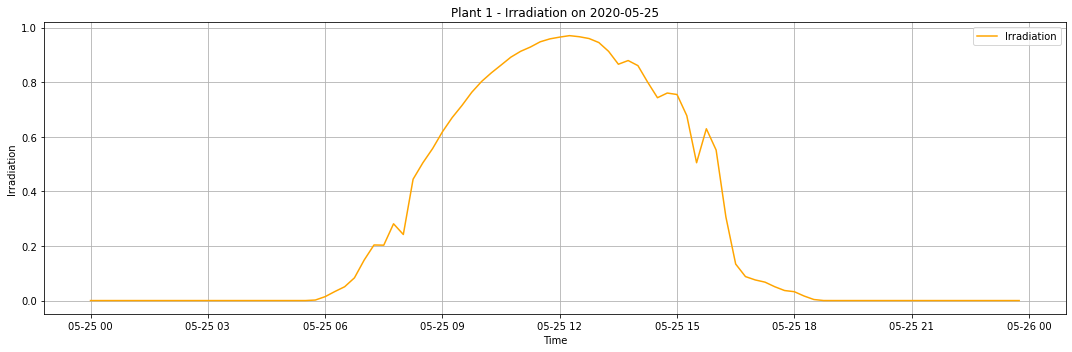


Plant 1 - 日期: 2020-05-28, 平均 Irradiance: 0.27, 總發電量: 733119.46


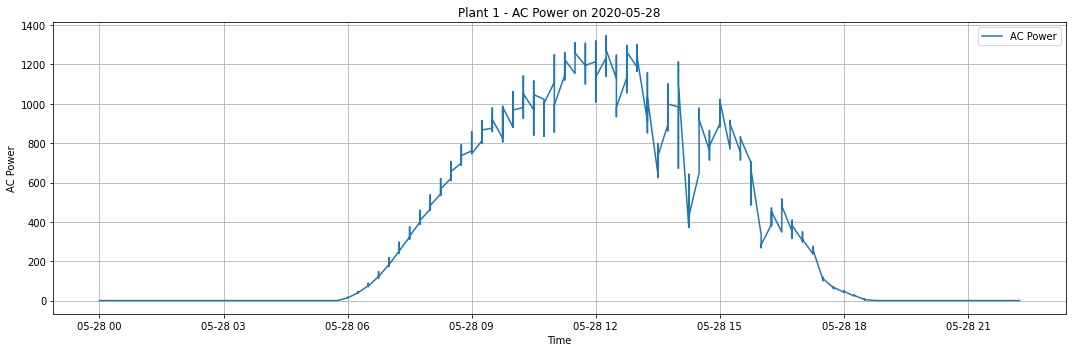

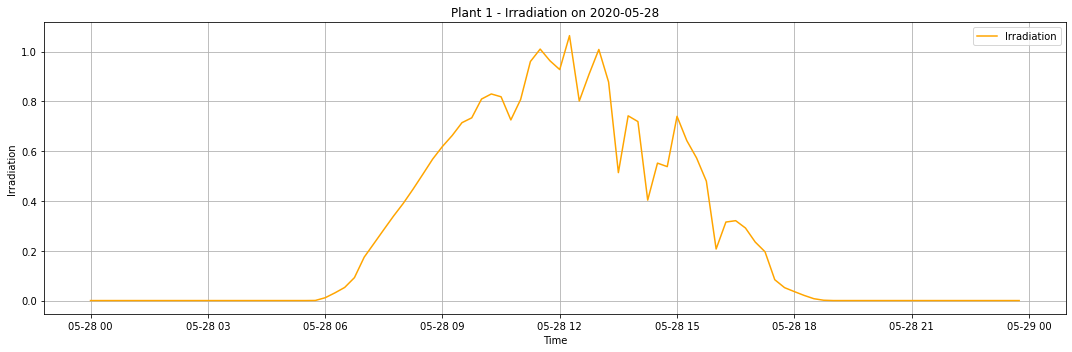


--- Plant 2 探索性資料分析 ---
錯誤：找不到 Plant_2_Generation_Data.csv 或 Plant_2_Weather_Sensor_Data.csv。請確認檔案路徑是否正確。


NameError: name 'plant_2_sensor' is not defined

In [1]:
# Set the folder path (modify according to your actual path)
folder_path = 'ECE657_dataset'

# Read Plant 1 generation and sensor data
generation_file_plant1 = 'Plant_1_Generation_Data.csv'
sensor_file_plant1 = 'Plant_1_Weather_Sensor_Data.csv'

generation_path_plant1 = os.path.join(folder_path, generation_file_plant1)
sensor_path_plant1 = os.path.join(folder_path, sensor_file_plant1)

try:
    plant_1_generation = pd.read_csv(generation_path_plant1)
    plant_1_sensor = pd.read_csv(sensor_path_plant1)
    print(f"Successfully loaded {generation_file_plant1} and {sensor_file_plant1}.")
except FileNotFoundError:
    print(f"Error: Could not find {generation_file_plant1} or {sensor_file_plant1}. Please check the file path.")
    exit()

# Convert DATE_TIME to datetime objects
plant_1_generation['DATE_TIME'] = pd.to_datetime(plant_1_generation['DATE_TIME'])
plant_1_sensor['DATE_TIME'] = pd.to_datetime(plant_1_sensor['DATE_TIME'])

print("\n--- Plant 1 Exploratory Data Analysis ---")

# 1. Daily variation of power generation (line plot) - Plant 1
daily_generation_p1 = plant_1_generation.groupby(plant_1_generation['DATE_TIME'].dt.date)['AC_POWER'].sum()

plt.figure(figsize=(12, 6))
plt.plot(daily_generation_p1.index, daily_generation_p1.values)
plt.title('Plant 1 - Daily Total AC Power Generation')
plt.xlabel('Date')
plt.ylabel('Total AC Power (sum)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2. Boxplot of power generation for each inverter to identify anomalies - Plant 1
plt.figure(figsize=(15, 8))
sns.boxplot(x='SOURCE_KEY', y='AC_POWER', data=plant_1_generation)
plt.title('Plant 1 - AC Power Distribution per Inverter')
plt.xlabel('Inverter Key')
plt.ylabel('AC Power')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 3. Check for a clear linear relationship between ambient temperature and power generation - Plant 1
merged_data_p1 = pd.merge(plant_1_generation, plant_1_sensor, on=['DATE_TIME', 'PLANT_ID'], how='inner')

plt.figure(figsize=(10, 6))
sns.scatterplot(x='AMBIENT_TEMPERATURE', y='AC_POWER', data=merged_data_p1)
plt.title('Plant 1 - Ambient Temperature vs AC Power')
plt.xlabel('Ambient Temperature')
plt.ylabel('AC Power')
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.regplot(x='AMBIENT_TEMPERATURE', y='AC_POWER', data=merged_data_p1, scatter_kws={'alpha':0.3})
plt.title('Plant 1 - Ambient Temperature vs AC Power with Regression Line')
plt.xlabel('Ambient Temperature')
plt.ylabel('AC Power')
plt.grid(True)
plt.tight_layout()
plt.show()

# 4. Identify days with high irradiance but low power generation -> potentially due to maintenance or soiling - Plant 1
high_irr_days_p1 = plant_1_sensor.groupby(plant_1_sensor['DATE_TIME'].dt.date)['IRRADIATION'].mean().nlargest(5)
print("\nPlant 1 - Top days with highest Irradiance:")
print(high_irr_days_p1)

for date in high_irr_days_p1.index:
    daily_gen = plant_1_generation[plant_1_generation['DATE_TIME'].dt.date == date]['AC_POWER'].sum()
    avg_irr = high_irr_days_p1[date]
    print(f"\nPlant 1 - Date: {date}, Average Irradiance: {avg_irr:.2f}, Total Generation: {daily_gen:.2f}")

    specific_day_gen = plant_1_generation[plant_1_generation['DATE_TIME'].dt.date == date].set_index('DATE_TIME')
    specific_day_irr = plant_1_sensor[plant_1_sensor['DATE_TIME'].dt.date == date].set_index('DATE_TIME')

    plt.figure(figsize=(15, 5))
    plt.plot(specific_day_gen.index, specific_day_gen['AC_POWER'], label='AC Power')
    plt.title(f'Plant 1 - AC Power on {date}')
    plt.xlabel('Time')
    plt.ylabel('AC Power')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(15, 5))
    plt.plot(specific_day_irr.index, specific_day_irr['IRRADIATION'], color='orange', label='Irradiation')
    plt.title(f'Plant 1 - Irradiation on {date}')
    plt.xlabel('Time')
    plt.ylabel('Irradiation')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


--- Plant 2 探索性資料分析 ---
成功載入 Plant_2_Generation_Data.csv 和 Plant_2_Weather_Sensor_Data.csv。


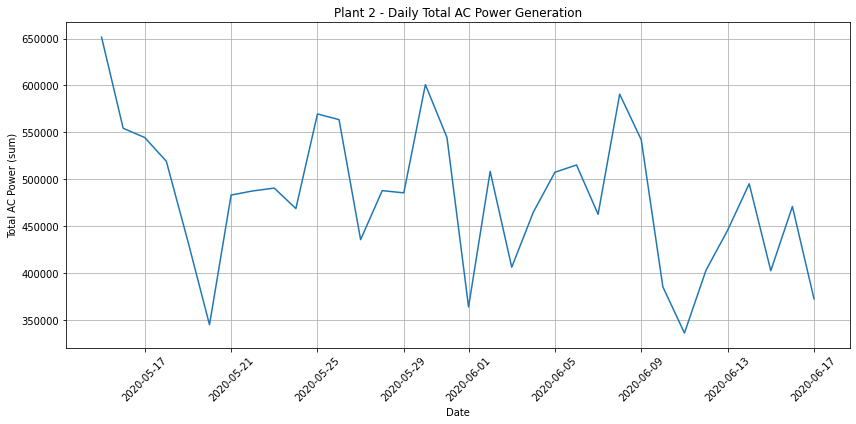

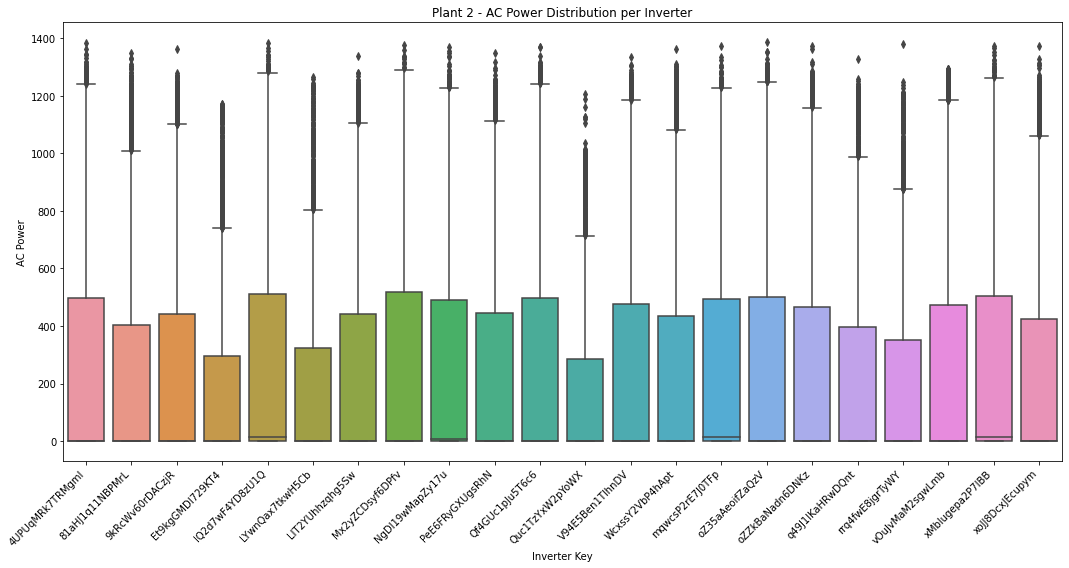

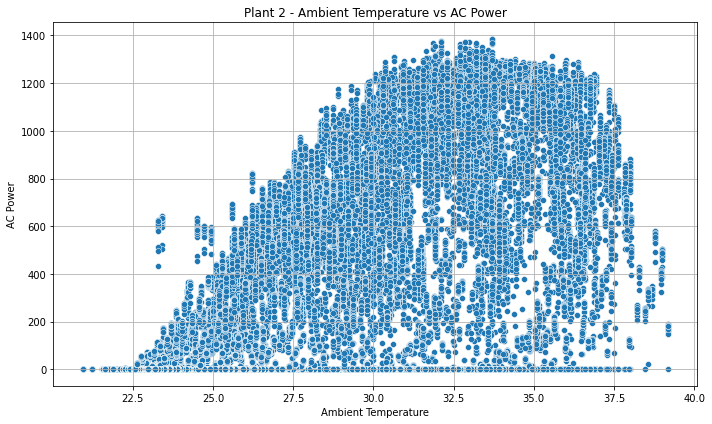

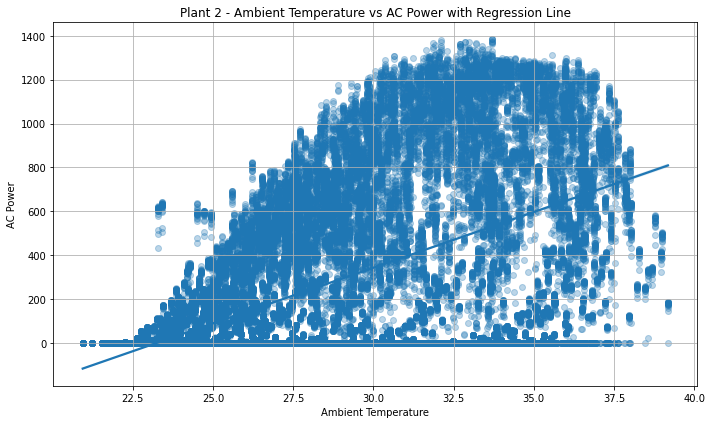


Plant 2 - Irradiance 最高的幾天：
DATE_TIME
2020-05-15    0.300622
2020-05-22    0.297248
2020-05-23    0.293333
2020-05-28    0.293094
2020-05-27    0.285749
Name: IRRADIATION, dtype: float64

Plant 2 - 日期: 2020-05-15, 平均 Irradiance: 0.30, 總發電量: 651437.74


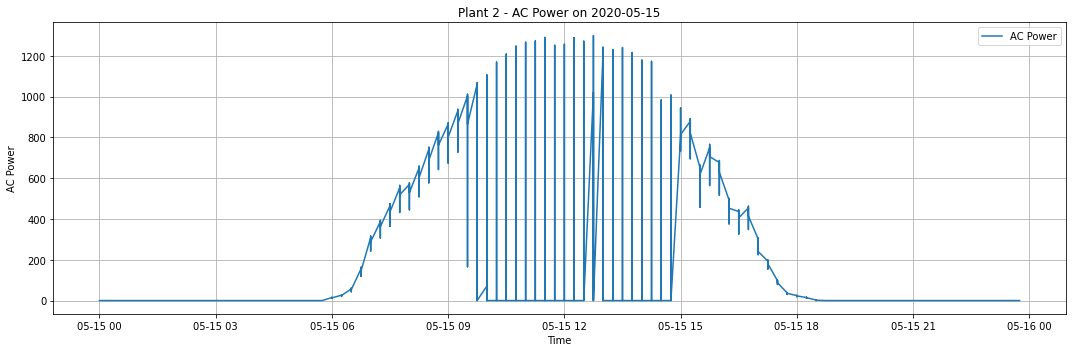

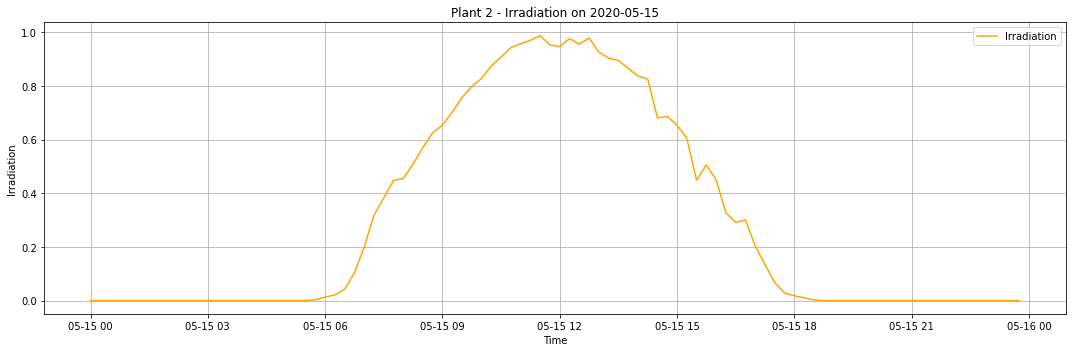


Plant 2 - 日期: 2020-05-22, 平均 Irradiance: 0.30, 總發電量: 487411.94


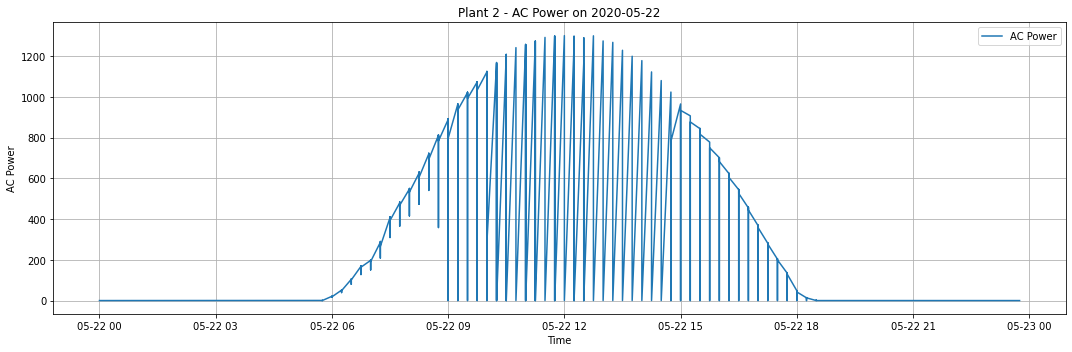

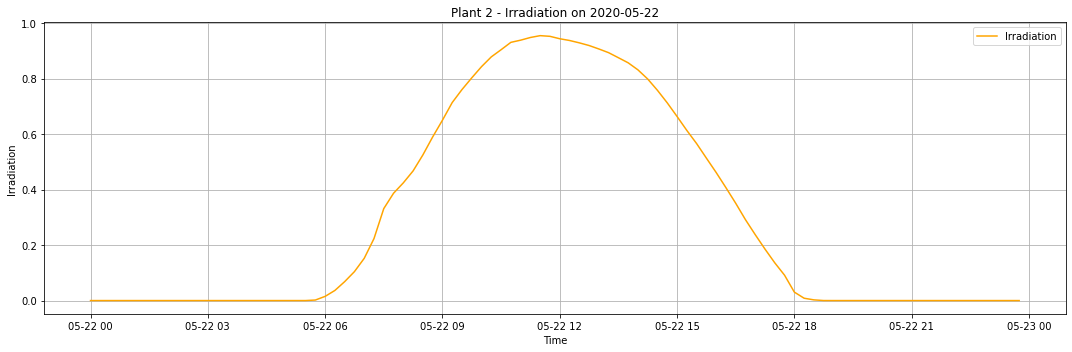


Plant 2 - 日期: 2020-05-23, 平均 Irradiance: 0.29, 總發電量: 490450.51


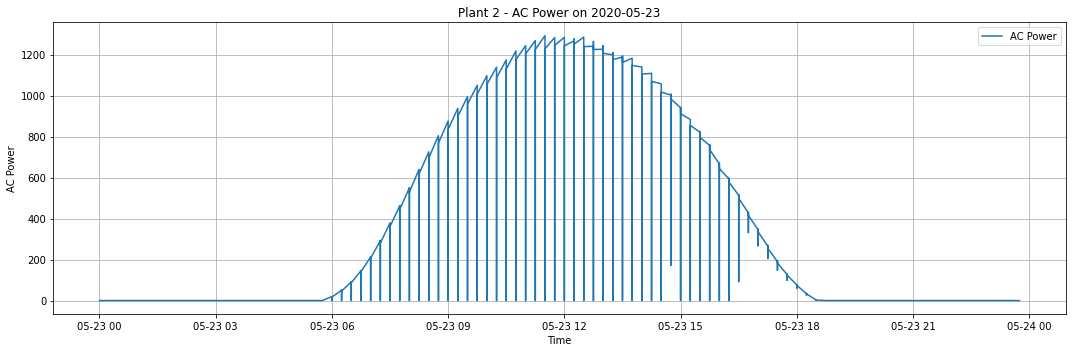

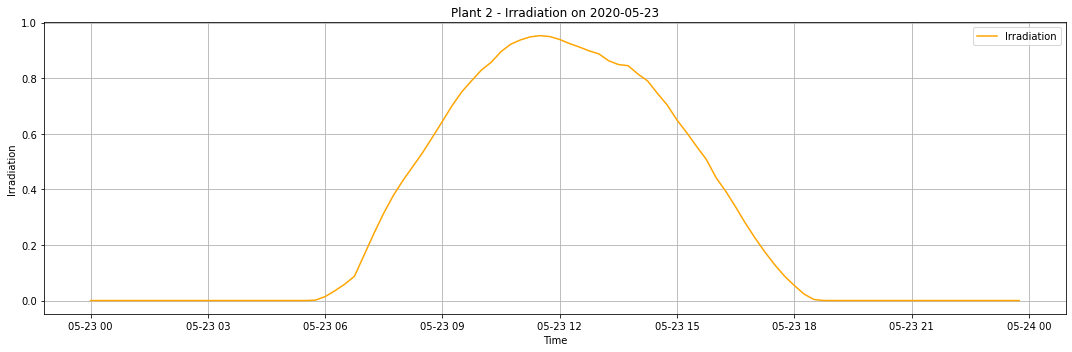


Plant 2 - 日期: 2020-05-28, 平均 Irradiance: 0.29, 總發電量: 487742.88


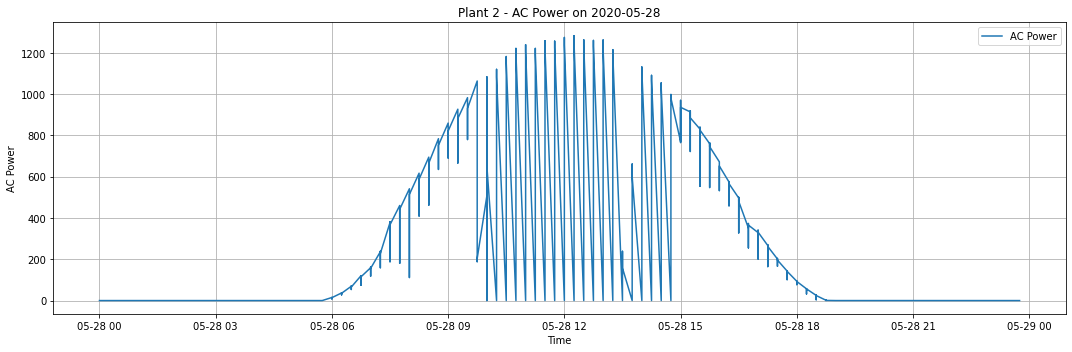

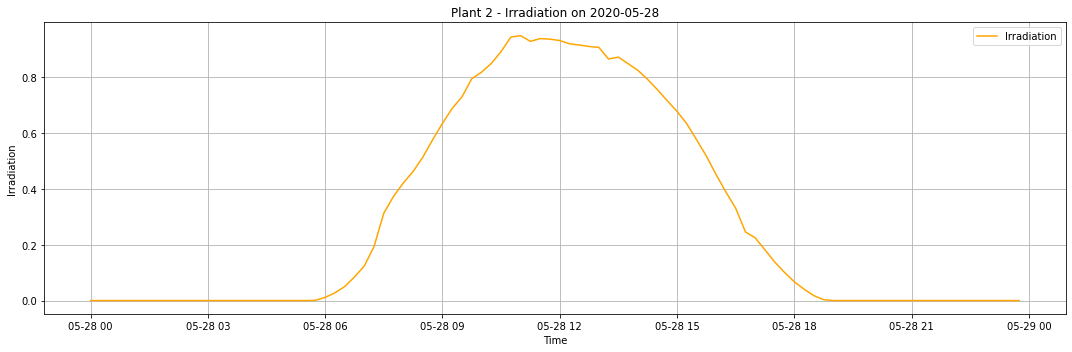


Plant 2 - 日期: 2020-05-27, 平均 Irradiance: 0.29, 總發電量: 435466.16


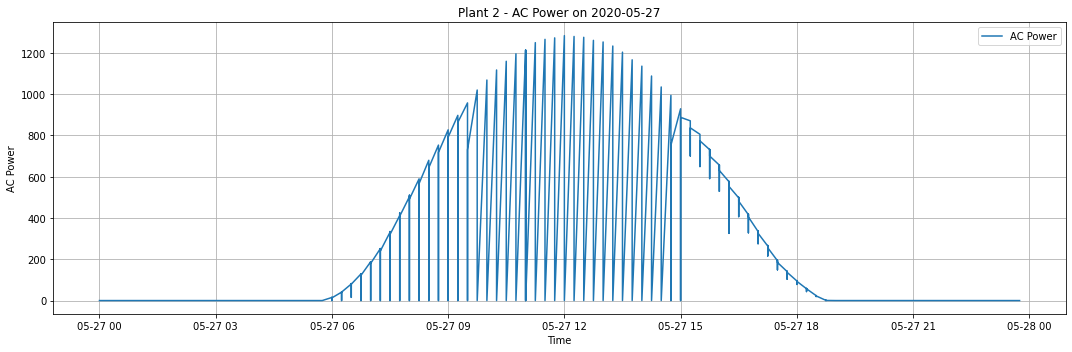

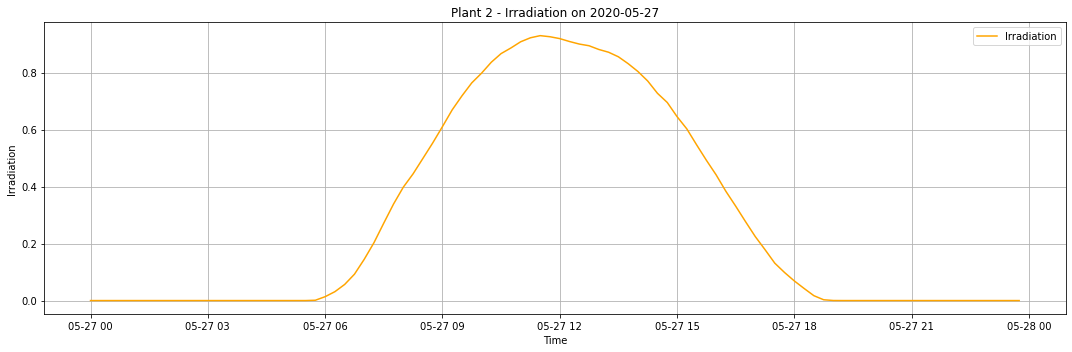


Plant 1 和 Plant 2 的探索性資料分析完成。請查看生成的圖表和輸出。


In [1]:
# Set the folder path (modify according to your actual path)
folder_path = 'ECE657_dataset'

# --- Exploratory Data Analysis for Plant 2 ---
print("\n--- Plant 2 Exploratory Data Analysis ---")

# Read Plant 2 generation and sensor data
generation_file_plant2 = 'Plant_2_Generation_Data.csv'
sensor_file_plant2 = 'Plant_2_Weather_Sensor_Data.csv'

generation_path_plant2 = os.path.join(folder_path, generation_file_plant2)
sensor_path_plant2 = os.path.join(folder_path, sensor_file_plant2)

try:
    plant_2_generation = pd.read_csv(generation_path_plant2)
    plant_2_sensor = pd.read_csv(sensor_path_plant2)
    print(f"Successfully loaded {generation_file_plant2} and {sensor_file_plant2}.")
except FileNotFoundError:
    print(f"Error: Could not find {generation_file_plant2} or {sensor_file_plant2}. Please check the file path.")
    exit()

# Convert DATE_TIME to datetime objects
plant_2_generation['DATE_TIME'] = pd.to_datetime(plant_2_generation['DATE_TIME'])
plant_2_sensor['DATE_TIME'] = pd.to_datetime(plant_2_sensor['DATE_TIME'])

# 1. Daily variation of power generation (line plot) - Plant 2
daily_generation_p2 = plant_2_generation.groupby(plant_2_generation['DATE_TIME'].dt.date)['AC_POWER'].sum()

plt.figure(figsize=(12, 6))
plt.plot(daily_generation_p2.index, daily_generation_p2.values)
plt.title('Plant 2 - Daily Total AC Power Generation')
plt.xlabel('Date')
plt.ylabel('Total AC Power (sum)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2. Boxplot of power generation for each inverter to identify anomalies - Plant 2
plt.figure(figsize=(15, 8))
sns.boxplot(x='SOURCE_KEY', y='AC_POWER', data=plant_2_generation)
plt.title('Plant 2 - AC Power Distribution per Inverter')
plt.xlabel('Inverter Key')
plt.ylabel('AC Power')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 3. Check for a clear linear relationship between ambient temperature and power generation - Plant 2
merged_data_p2 = pd.merge(plant_2_generation, plant_2_sensor, on=['DATE_TIME', 'PLANT_ID'], how='inner')

plt.figure(figsize=(10, 6))
sns.scatterplot(x='AMBIENT_TEMPERATURE', y='AC_POWER', data=merged_data_p2)
plt.title('Plant 2 - Ambient Temperature vs AC Power')
plt.xlabel('Ambient Temperature')
plt.ylabel('AC Power')
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.regplot(x='AMBIENT_TEMPERATURE', y='AC_POWER', data=merged_data_p2, scatter_kws={'alpha':0.3})
plt.title('Plant 2 - Ambient Temperature vs AC Power with Regression Line')
plt.xlabel('Ambient Temperature')
plt.ylabel('AC Power')
plt.grid(True)
plt.tight_layout()
plt.show()

# 4. Identify days with high irradiance but low power generation -> potentially due to maintenance or soiling - Plant 2
high_irr_days_p2 = plant_2_sensor.groupby(plant_2_sensor['DATE_TIME'].dt.date)['IRRADIATION'].mean().nlargest(5)
print("\nPlant 2 - Top days with highest Irradiance:")
print(high_irr_days_p2)

for date in high_irr_days_p2.index:
    daily_gen = plant_2_generation[plant_2_generation['DATE_TIME'].dt.date == date]['AC_POWER'].sum()
    avg_irr = high_irr_days_p2[date]
    print(f"\nPlant 2 - Date: {date}, Average Irradiance: {avg_irr:.2f}, Total Generation: {daily_gen:.2f}")

    specific_day_gen = plant_2_generation[plant_2_generation['DATE_TIME'].dt.date == date].set_index('DATE_TIME')
    specific_day_irr = plant_2_sensor[plant_2_sensor['DATE_TIME'].dt.date == date].set_index('DATE_TIME')

    plt.figure(figsize=(15, 5))
    plt.plot(specific_day_gen.index, specific_day_gen['AC_POWER'], label='AC Power')
    plt.title(f'Plant 2 - AC Power on {date}')
    plt.xlabel('Time')
    plt.ylabel('AC Power')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(15, 5))
    plt.plot(specific_day_irr.index, specific_day_irr['IRRADIATION'], color='orange', label='Irradiation')
    plt.title(f'Plant 2 - Irradiation on {date}')
    plt.xlabel('Time')
    plt.ylabel('Irradiation')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

print("\nExploratory Data Analysis for Plant 1 and Plant 2 completed. Please check the generated charts and output.")

In [2]:
# Set the folder path
folder_path = 'ECE657_dataset'

# Initialize two dictionaries to store data
plant_1_data = {}
plant_2_data = {}

# Read Plant 1 data
generation_file_plant1 = 'Plant_1_Generation_Data.csv'
sensor_file_plant1 = 'Plant_1_Weather_Sensor_Data.csv'

generation_path_plant1 = os.path.join(folder_path, generation_file_plant1)
sensor_path_plant1 = os.path.join(folder_path, sensor_file_plant1)

try:
    plant_1_data['generation'] = pd.read_csv(generation_path_plant1)
    plant_1_data['sensor'] = pd.read_csv(sensor_path_plant1)
    print(f"Successfully loaded {generation_file_plant1} and {sensor_file_plant1}.")
except FileNotFoundError:
    print(f"Error: Could not find {generation_file_plant1} or {sensor_file_plant1}. Please check the file path.")

# Read Plant 2 data
generation_file_plant2 = 'Plant_2_Generation_Data.csv'
sensor_file_plant2 = 'Plant_2_Weather_Sensor_Data.csv'

generation_path_plant2 = os.path.join(folder_path, generation_file_plant2)
sensor_path_plant2 = os.path.join(folder_path, sensor_file_plant2)

try:
    plant_2_data['generation'] = pd.read_csv(generation_path_plant2)
    plant_2_data['sensor'] = pd.read_csv(sensor_path_plant2)
    print(f"Successfully loaded {generation_file_plant2} and {sensor_file_plant2}.")
except FileNotFoundError:
    print(f"Error: Could not find {generation_file_plant2} or {sensor_file_plant2}. Please check the file path.")

成功載入 Plant_1_Generation_Data.csv 和 Plant_1_Weather_Sensor_Data.csv。
成功載入 Plant_2_Generation_Data.csv 和 Plant_2_Weather_Sensor_Data.csv。


In [3]:
# You can optionally view basic information about the loaded data
if plant_1_data:
    print("\nPlant 1 Generation Data Information:")
    print(plant_1_data['generation'].info())
    print("\nPlant 1 Sensor Data Information:")
    print(plant_1_data['sensor'].info())

if plant_2_data:
    print("\nPlant 2 Generation Data Information:")
    print(plant_2_data['generation'].info())
    print("\nPlant 2 Sensor Data Information:")
    print(plant_2_data['sensor'].info())


Plant 1 發電數據資訊：
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68778 entries, 0 to 68777
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DATE_TIME    68778 non-null  object 
 1   PLANT_ID     68778 non-null  int64  
 2   SOURCE_KEY   68778 non-null  object 
 3   DC_POWER     68778 non-null  float64
 4   AC_POWER     68778 non-null  float64
 5   DAILY_YIELD  68778 non-null  float64
 6   TOTAL_YIELD  68778 non-null  float64
dtypes: float64(4), int64(1), object(2)
memory usage: 3.7+ MB
None

Plant 1 感測器數據資訊：
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3182 entries, 0 to 3181
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   DATE_TIME            3182 non-null   object 
 1   PLANT_ID             3182 non-null   int64  
 2   SOURCE_KEY           3182 non-null   object 
 3   AMBIENT_TEMPERATURE  3182 non-null   float64
 4   M

In [2]:
# Set the folder path
folder_path = 'ECE657_dataset'

# Initialize two dictionaries to store data (Plant 2 will no longer be used)
plant_1_data = {}
# plant_2_data = {}

# Read Plant 1 data
generation_file_plant1 = 'Plant_1_Generation_Data.csv'
sensor_file_plant1 = 'Plant_1_Weather_Sensor_Data.csv'

generation_path_plant1 = os.path.join(folder_path, generation_file_plant1)
sensor_path_plant1 = os.path.join(folder_path, sensor_file_plant1)

try:
    plant_1_data['generation'] = pd.read_csv(generation_path_plant1)
    plant_1_data['sensor'] = pd.read_csv(sensor_path_plant1)
    print(f"Successfully loaded {generation_file_plant1} and {sensor_file_plant1}.")
except FileNotFoundError:
    print(f"Error: Could not find {generation_file_plant1} or {sensor_file_plant1}. Please check the file path.")
    exit()

# # Read Plant 2 data (commented out)
# generation_file_plant2 = 'Plant_2_Generation_Data.csv'
# sensor_file_plant2 = 'Plant_2_Weather_Sensor_Data.csv'
#
# generation_path_plant2 = os.path.join(folder_path, generation_file_plant2)
# sensor_path_plant2 = os.path.join(folder_path, sensor_file_plant2)
#
# try:
#     plant_2_data['generation'] = pd.read_csv(generation_path_plant2)
#     plant_2_data['sensor'] = pd.read_csv(sensor_file_plant2)
#     print(f"Successfully loaded {generation_file_plant2} and {sensor_file_plant2}.")
# except FileNotFoundError:
#     print(f"Error: Could not find {generation_file_plant2} or {sensor_file_plant2}. Please check the file path.")
#     exit()

# Merge Plant 1 generation and sensor data
if plant_1_data and 'generation' in plant_1_data and 'sensor' in plant_1_data:
    plant_1_generation = plant_1_data['generation'].rename(columns={'DATE_TIME': 'TIMESTAMP', 'SOURCE_KEY': 'INVERTER_KEY'}) # More descriptive naming
    plant_1_sensor = plant_1_data['sensor'].rename(columns={'DATE_TIME': 'TIMESTAMP', 'SOURCE_KEY': 'WEATHER_KEY'}) # More descriptive naming
    plant_1_generation['TIMESTAMP'] = pd.to_datetime(plant_1_generation['TIMESTAMP'])
    plant_1_sensor['TIMESTAMP'] = pd.to_datetime(plant_1_sensor['TIMESTAMP'])
    merged_data_p1 = pd.merge(plant_1_generation, plant_1_sensor, on=['TIMESTAMP', 'PLANT_ID'], how='inner')
    print(f"Plant 1 merged data size: {merged_data_p1.shape}")
else:
    merged_data_p1 = pd.DataFrame()
    print("Plant 1 data not loaded successfully, unable to merge.")
    exit() # Exit if Plant 1 data loading fails

# # Merge Plant 2 generation and sensor data (commented out)
# if plant_2_data and 'generation' in plant_2_data and 'sensor' in plant_2_data:
#     plant_2_generation = plant_2_data['generation'].rename(columns={'DATE_TIME': 'TIMESTAMP', 'SOURCE_KEY': 'INVERTER_KEY'}) # More descriptive naming
#     plant_2_sensor = plant_2_data['sensor'].rename(columns={'DATE_TIME': 'TIMESTAMP', 'SOURCE_KEY': 'WEATHER_KEY'}) # More descriptive naming
#     plant_2_generation['TIMESTAMP'] = pd.to_datetime(plant_2_generation['TIMESTAMP'])
#     plant_2_sensor['TIMESTAMP'] = pd.to_datetime(plant_2_sensor['TIMESTAMP'])
#     merged_data_p2 = pd.merge(plant_2_generation, plant_2_sensor, on=['TIMESTAMP', 'PLANT_ID'], how='inner')
#     print(f"Plant 2 merged data size: {merged_data_p2.shape}")
# else:
#     merged_data_p2 = pd.DataFrame()
#     print("Plant 2 data not loaded successfully, unable to merge.")
#     merged_data_p2 = pd.DataFrame() # Ensure merged_data_p2 is empty

# Merge the merged data for Plant 1 and Plant 2 (now only using Plant 1)
if not merged_data_p1.empty:
    merged_data = merged_data_p1.sort_values(by=['INVERTER_KEY', 'TIMESTAMP']) # Sort by INVERTER_KEY and TIMESTAMP
    merged_data['hour'] = merged_data['TIMESTAMP'].dt.hour
    merged_data['dayofweek'] = merged_data['TIMESTAMP'].dt.dayofweek
    merged_data['dayofyear'] = merged_data['TIMESTAMP'].dt.dayofyear

    def create_lagged_features(df, lag_steps=1):
        df['prev_ac_power'] = df.groupby('INVERTER_KEY')['AC_POWER'].shift(lag_steps) # Group by INVERTER_KEY
        df['prev_dc_power'] = df.groupby('INVERTER_KEY')['DC_POWER'].shift(lag_steps) # Group by INVERTER_KEY
        return df

    merged_data = create_lagged_features(merged_data.copy())
    merged_data = merged_data.dropna()
else:
    merged_data = pd.DataFrame()
    print("Plant 1 merged data is empty, unable to proceed with further processing.")
    exit()

train_data_list = []
test_data_list = []

if not merged_data.empty:
    grouped = merged_data.groupby('INVERTER_KEY')
    for key, group in grouped:
        n_samples = len(group)
        train_size = int(0.8 * n_samples)
        train_data_list.append(group[:train_size])
        test_data_list.append(group[train_size:])

    train_data_all = pd.concat(train_data_list, ignore_index=True)
    test_data_all = pd.concat(test_data_list, ignore_index=True)

    # Define feature types
    numerical_features = ['AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION', 'prev_dc_power', 'prev_ac_power']
    categorical_feature = ['INVERTER_KEY']
    time_features = ['hour', 'dayofweek', 'dayofyear']
    target_features = ['DC_POWER', 'AC_POWER']
    other_features_to_drop = ['TIMESTAMP', 'PLANT_ID', 'DAILY_YIELD', 'TOTAL_YIELD', 'WEATHER_KEY']

    # Separate features
    train_numerical = train_data_all[numerical_features].copy()
    test_numerical = test_data_all[numerical_features].copy()
    train_categorical = train_data_all[categorical_feature].copy()
    test_categorical = test_data_all[categorical_feature].copy()
    train_time = train_data_all[time_features].copy()
    test_time = test_data_all[time_features].copy()
    print("\nPlant 1 Training Set Numerical Features:", train_numerical.columns)
    print("\nPlant 1 Testing Set Numerical Features:", test_numerical.columns)

    # Initialize MinMaxScaler
    temp_scaler = MinMaxScaler()
    irr_scaler = MinMaxScaler()
    dc_power_scaler = MinMaxScaler()
    ac_power_scaler = MinMaxScaler()

    # Fit scaler on training data and transform training and testing data
    train_numerical[numerical_features[:2]] = temp_scaler.fit_transform(train_numerical[numerical_features[:2]])
    test_numerical[numerical_features[:2]] = temp_scaler.transform(test_numerical[numerical_features[:2]])

    train_numerical[['IRRADIATION']] = irr_scaler.fit_transform(train_numerical[['IRRADIATION']])
    test_numerical[['IRRADIATION']] = irr_scaler.transform(test_numerical[['IRRADIATION']])

    train_numerical[['prev_dc_power']] = dc_power_scaler.fit_transform(train_numerical[['prev_dc_power']])
    test_numerical[['prev_dc_power']] = dc_power_scaler.transform(test_numerical[['prev_dc_power']])

    train_numerical[['prev_ac_power']] = ac_power_scaler.fit_transform(train_numerical[['prev_ac_power']])
    test_numerical[['prev_ac_power']] = ac_power_scaler.transform(test_numerical[['prev_ac_power']])

    # Set file paths for saving scalers (still saving Plant 1 scalers)
    temp_scaler_path = os.path.join(folder_path, 'temp_scaler_plant1.joblib')
    irr_scaler_path = os.path.join(folder_path, 'irr_scaler_plant1.joblib')
    dc_power_scaler_path = os.path.join(folder_path, 'dc_power_scaler_plant1.joblib')
    ac_power_scaler_path = os.path.join(folder_path, 'ac_power_scaler_plant1.joblib')

    # Save scalers (Plant 1 scalers)
    joblib.dump(temp_scaler, temp_scaler_path)
    print(f"Plant 1 temp_scaler saved to: {temp_scaler_path}")

    joblib.dump(irr_scaler, irr_scaler_path)
    print(f"Plant 1 irr_scaler saved to: {irr_scaler_path}")

    joblib.dump(dc_power_scaler, dc_power_scaler_path)
    print(f"Plant 1 dc_power_scaler saved to: {dc_power_scaler_path}")

    joblib.dump(ac_power_scaler, ac_power_scaler_path)
    print(f"Plant 1 ac_power_scaler saved to: {ac_power_scaler_path}")

    print("\nAll scalers for Plant 1 saved successfully.")

    # Perform One-Hot Encoding
    encoder = OneHotEncoder(handle_unknown='ignore')
    X_train_encoded = encoder.fit_transform(train_categorical).toarray()
    X_test_encoded = encoder.transform(test_categorical).toarray()
    encoder_path = os.path.join(folder_path, 'onehot_encoder_plant1.joblib')
    joblib.dump(encoder, encoder_path)
    print(f"Plant 1 onehot_encoder saved to: {encoder_path}")

    encoded_feature_names = [f'INVERTER_KEY_{cat}' for cat in encoder.categories_[0]]

    X_train_encoded_df = pd.DataFrame(X_train_encoded, index=train_categorical.index, columns=encoded_feature_names)
    X_test_encoded_df = pd.DataFrame(X_test_encoded, index=test_categorical.index, columns=encoded_feature_names)

    # Merge features
    X_train_scaled = pd.concat([train_numerical.reset_index(drop=True), X_train_encoded_df.reset_index(drop=True), train_time.reset_index(drop=True)], axis=1)
    X_test_scaled = pd.concat([test_numerical.reset_index(drop=True), X_test_encoded_df.reset_index(drop=True), test_time.reset_index(drop=True)], axis=1)

    # Prepare X and y for predicting DC_POWER and AC_POWER separately
    def prepare_data_scaled(X, df, target_column): # Added scaler as an argument
        y = df[target_column].copy()
        return X, y

    X_train_dc_scaled, y_train_dc = prepare_data_scaled(X_train_scaled.copy(), train_data_all, 'DC_POWER')
    X_test_dc_scaled, y_test_dc = prepare_data_scaled(X_test_scaled.copy(), test_data_all, 'DC_POWER')

    X_train_ac_scaled, y_train_ac = prepare_data_scaled(X_train_scaled.copy(), train_data_all, 'AC_POWER')
    X_test_ac_scaled, y_test_ac = prepare_data_scaled(X_test_scaled.copy(), test_data_all, 'AC_POWER')

    print("\nPlant 1 Scaled and One-Hot Encoded Training Set Features (DC_POWER) Head:")
    print(X_train_dc_scaled.head())
    print("\nPlant 1 Training Set (DC_POWER) Target Variable Head:")
    print(y_train_dc.head())
    print("\nPlant 1 Scaled and One-Hot Encoded Testing Set Features (DC_POWER) Head:")
    print(X_test_dc_scaled.head())
    print("\nPlant 1 Testing Set (DC_POWER) Target Variable Head:")
    print(y_test_dc.head())

    print("\nPlant 1 Scaled and One-Hot Encoded Training Set Features (AC_POWER) Head:")
    print(X_train_ac_scaled.head())
    print("\nPlant 1 Testing Set (AC_POWER) Target Variable Head:")
    print(y_test_ac.head())
else:
    print("Plant 1 merged data is empty, unable to split into training and testing sets.")

成功載入 Plant_1_Generation_Data.csv 和 Plant_1_Weather_Sensor_Data.csv。
Plant 1 合併後的數據大小：(45680, 11)

Plant 1 訓練集數值特徵欄位: Index(['AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION',
       'prev_dc_power', 'prev_ac_power'],
      dtype='object')

Plant 1 測試集數值特徵欄位: Index(['AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION',
       'prev_dc_power', 'prev_ac_power'],
      dtype='object')
Plant 1 temp_scaler 已保存到：ECE657_dataset\temp_scaler_plant1.joblib
Plant 1 irr_scaler 已保存到：ECE657_dataset\irr_scaler_plant1.joblib
Plant 1 dc_power_scaler 已保存到：ECE657_dataset\dc_power_scaler_plant1.joblib
Plant 1 ac_power_scaler 已保存到：ECE657_dataset\ac_power_scaler_plant1.joblib

Plant 1 所有 scaler 已成功保存。
Plant 1 onehot_encoder 已保存到：ECE657_dataset\onehot_encoder_plant1.joblib

Plant 1 縮放並 One-Hot Encoding 後的訓練集 (DC_POWER) 特徵前幾行:
   AMBIENT_TEMPERATURE  MODULE_TEMPERATURE  IRRADIATION  prev_dc_power  \
0             0.315477            0.097484          0.0            0.0   
1             0.305457 

   AMBIENT_TEMPERATURE  MODULE_TEMPERATURE  IRRADIATION  prev_dc_power  \
0             0.429037            0.596822     0.544654       0.711824   
1             0.432898            0.595284     0.665071       0.556851   
2             0.483694            0.628767     0.637406       0.703492   
3             0.516944            0.604705     0.649710       0.689339   
4             0.519345            0.592746     0.492566       0.624303   

   prev_ac_power  INVERTER_KEY_1BY6WEcLGh8j5v7  INVERTER_KEY_1IF53ai7Xc0U56Y  \
0       0.713248                           1.0                           0.0   
1       0.558628                           1.0                           0.0   
2       0.705441                           1.0                           0.0   
3       0.691358                           1.0                           0.0   
4       0.626342                           1.0                           0.0   

   INVERTER_KEY_3PZuoBAID5Wc2HD  INVERTER_KEY_7JYdWkrLSPkdwr4  \
0        

In [2]:
# Set the folder path
folder_path = 'ECE657_dataset'

# Initialize a dictionary to store Plant 1 data
plant_1_data = {}

# Read Plant 1 data
generation_file_plant1 = 'Plant_1_Generation_Data.csv'
sensor_file_plant1 = 'Plant_1_Weather_Sensor_Data.csv'

generation_path_plant1 = os.path.join(folder_path, generation_file_plant1)
sensor_path_plant1 = os.path.join(folder_path, sensor_file_plant1)

try:
    plant_1_data['generation'] = pd.read_csv(generation_path_plant1)
    plant_1_data['sensor'] = pd.read_csv(sensor_path_plant1)
    print(f"Successfully loaded {generation_file_plant1} and {sensor_file_plant1}.")
except FileNotFoundError:
    print(f"Error: Could not find {generation_file_plant1} or {sensor_file_plant1}. Please check the file path.")
    exit()

# Preprocess timestamps
plant_1_data['generation']['DATE_TIME'] = pd.to_datetime(plant_1_data['generation']['DATE_TIME'])
plant_1_data['sensor']['DATE_TIME'] = pd.to_datetime(plant_1_data['sensor']['DATE_TIME'])

# Find the time range of Plant 1 weather data
weather_start_time_p1 = plant_1_data['sensor']['DATE_TIME'].min()
weather_end_time_p1 = plant_1_data['sensor']['DATE_TIME'].max()
print(f"\nPlant 1 Weather Data Time Range:")
print(f"  Start Time: {weather_start_time_p1}")
print(f"  End Time: {weather_end_time_p1}")

# Merge Plant 1 generation and sensor data, keeping only records within the weather data time range
if plant_1_data and 'generation' in plant_1_data and 'sensor' in plant_1_data:
    plant_1_generation = plant_1_data['generation'].rename(columns={'DATE_TIME': 'TIMESTAMP', 'SOURCE_KEY': 'INVERTER_KEY'}) # More descriptive naming
    plant_1_sensor = plant_1_data['sensor'].rename(columns={'DATE_TIME': 'TIMESTAMP', 'SOURCE_KEY': 'WEATHER_KEY'}) # More descriptive naming
    plant_1_generation['TIMESTAMP'] = pd.to_datetime(plant_1_generation['TIMESTAMP'])
    plant_1_sensor['TIMESTAMP'] = pd.to_datetime(plant_1_sensor['TIMESTAMP'])

    # Filter generation data to keep only records within the weather data time range
    plant_1_generation_filtered = plant_1_generation[
        (plant_1_generation['TIMESTAMP'] >= weather_start_time_p1) &
        (plant_1_generation['TIMESTAMP'] <= weather_end_time_p1)
    ]

    merged_data_p1 = pd.merge(plant_1_generation_filtered, plant_1_sensor, on=['TIMESTAMP', 'PLANT_ID'], how='inner')
    print(f"Plant 1 Merged Data Size (within weather data time range): {merged_data_p1.shape}")
else:
    merged_data_p1 = pd.DataFrame()
    print("Plant 1 data not loaded successfully, unable to merge.")
    exit() # Exit if Plant 1 data loading fails

# Subsequent data processing steps
if not merged_data_p1.empty:
    merged_data = merged_data_p1.sort_values(by=['INVERTER_KEY', 'TIMESTAMP']) # Sort by INVERTER_KEY and TIMESTAMP
    merged_data['hour'] = merged_data['TIMESTAMP'].dt.hour
    merged_data['dayofweek'] = merged_data['TIMESTAMP'].dt.dayofweek
    merged_data['dayofyear'] = merged_data['TIMESTAMP'].dt.dayofyear

    def create_future_target(df, lag_steps=1, target_column='AC_POWER'):
        df[f'next_{target_column.lower()}'] = df.groupby('INVERTER_KEY')[target_column].shift(-lag_steps)
        return df

    merged_data = create_future_target(merged_data.copy())
    merged_data = merged_data.dropna()
else:
    merged_data = pd.DataFrame()
    print("Plant 1 merged data is empty, unable to proceed with further processing.")
    exit()

train_data_list = []
test_data_list = []

if not merged_data.empty:
    grouped = merged_data.groupby('INVERTER_KEY')
    for key, group in grouped:
        n_samples = len(group)
        train_size = int(0.8 * n_samples)
        train_data_list.append(group[:train_size])
        test_data_list.append(group[train_size:])

    train_data_all = pd.concat(train_data_list, ignore_index=True)
    test_data_all = pd.concat(test_data_list, ignore_index=True)

    # Define feature types (now includes current timestep DC/AC POWER)
    numerical_features = ['AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION', 'DC_POWER', 'AC_POWER']
    categorical_feature = ['INVERTER_KEY']
    time_features = ['hour', 'dayofweek', 'dayofyear']
    target_feature = ['next_ac_power'] # Target is the next timestep's AC_POWER
    other_features_to_drop = ['TIMESTAMP', 'PLANT_ID', 'DAILY_YIELD', 'TOTAL_YIELD', 'WEATHER_KEY', 'next_dc_power'] # Remove next_dc_power

    # Separate features
    train_numerical = train_data_all[numerical_features].copy()
    test_numerical = test_data_all[numerical_features].copy()
    train_categorical = train_data_all[categorical_feature].copy()
    test_categorical = test_data_all[categorical_feature].copy()
    train_time = train_data_all[time_features].copy()
    test_time = test_data_all[time_features].copy()
    y_train_ac = train_data_all[target_feature].copy()
    y_test_ac = test_data_all[target_feature].copy()

    print("\nPlant 1 Training Set Numerical Feature Columns:", train_numerical.columns)
    print("\nPlant 1 Testing Set Numerical Feature Columns:", test_numerical.columns)
    print("\nPlant 1 Training Set Target Variable (Next AC_POWER) Head:")
    print(y_train_ac.head())
    print("\nPlant 1 Testing Set Target Variable (Next AC_POWER) Head:")
    print(y_test_ac.head())

    # Initialize MinMaxScaler
    temp_scaler = MinMaxScaler()
    irr_scaler = MinMaxScaler()
    dc_power_scaler = MinMaxScaler()
    ac_power_scaler = MinMaxScaler()

    # Fit scaler on training data and transform training and testing data
    train_numerical[numerical_features[:2]] = temp_scaler.fit_transform(train_numerical[numerical_features[:2]])
    test_numerical[numerical_features[:2]] = temp_scaler.transform(test_numerical[numerical_features[:2]])

    train_numerical[['IRRADIATION']] = irr_scaler.fit_transform(train_numerical[['IRRADIATION']])
    test_numerical[['IRRADIATION']] = irr_scaler.transform(test_numerical[['IRRADIATION']])

    train_numerical[['DC_POWER']] = dc_power_scaler.fit_transform(train_numerical[['DC_POWER']])
    test_numerical[['DC_POWER']] = dc_power_scaler.transform(test_numerical[['DC_POWER']])

    train_numerical[['AC_POWER']] = ac_power_scaler.fit_transform(train_numerical[['AC_POWER']])
    test_numerical[['AC_POWER']] = ac_power_scaler.transform(test_numerical[['AC_POWER']])

    # Set file paths for saving scalers
    temp_scaler_path = os.path.join(folder_path, 'temp_scaler_plant1.joblib')
    irr_scaler_path = os.path.join(folder_path, 'irr_scaler_plant1.joblib')
    dc_power_scaler_path = os.path.join(folder_path, 'dc_power_scaler_plant1.joblib')
    ac_power_scaler_path = os.path.join(folder_path, 'ac_power_scaler_plant1.joblib')

    # Save scalers
    joblib.dump(temp_scaler, temp_scaler_path)
    print(f"Plant 1 temp_scaler saved to: {temp_scaler_path}")

    joblib.dump(irr_scaler, irr_scaler_path)
    print(f"Plant 1 irr_scaler saved to: {irr_scaler_path}")

    joblib.dump(dc_power_scaler, dc_power_scaler_path)
    print(f"Plant 1 dc_power_scaler saved to: {dc_power_scaler_path}")

    joblib.dump(ac_power_scaler, ac_power_scaler_path)
    print(f"Plant 1 ac_power_scaler saved to: {ac_power_scaler_path}")

    print("\nAll scalers for Plant 1 saved successfully.")

    # Perform One-Hot Encoding
    encoder = OneHotEncoder(handle_unknown='ignore')
    X_train_encoded = encoder.fit_transform(train_categorical).toarray()
    X_test_encoded = encoder.transform(test_categorical).toarray()
    encoder_path = os.path.join(folder_path, 'onehot_encoder_plant1.joblib')
    joblib.dump(encoder, encoder_path)
    print(f"Plant 1 onehot_encoder saved to: {encoder_path}")

    encoded_feature_names = [f'INVERTER_KEY_{cat}' for cat in encoder.categories_[0]]

    X_train_encoded_df = pd.DataFrame(X_train_encoded, index=train_categorical.index, columns=encoded_feature_names)
    X_test_encoded_df = pd.DataFrame(X_test_encoded, index=test_categorical.index, columns=encoded_feature_names)

    # Merge features
    X_train_scaled = pd.concat([train_numerical.reset_index(drop=True), X_train_encoded_df.reset_index(drop=True), train_time.reset_index(drop=True)], axis=1)
    X_test_scaled = pd.concat([test_numerical.reset_index(drop=True), X_test_encoded_df.reset_index(drop=True), test_time.reset_index(drop=True)], axis=1)

    print("\nPlant 1 Scaled and One-Hot Encoded Training Set Features (Predicting Next AC_POWER) Head:")
    print(X_train_scaled.head())
    print("\nPlant 1 Training Set Target Variable (Next AC_POWER) Head:")
    print(y_train_ac.head())
    print("\nPlant 1 Scaled and One-Hot Encoded Testing Set Features (Predicting Next AC_POWER) Head:")
    print(X_test_scaled.head())
    print("\nPlant 1 Testing Set Target Variable (Next AC_POWER) Head:")
    print(y_test_ac.head())

else:
    print("Plant 1 merged data is empty, unable to split into training and testing sets.")

成功載入 Plant_1_Generation_Data.csv 和 Plant_1_Weather_Sensor_Data.csv。

Plant 1 天氣數據時間範圍：
  開始時間: 2020-05-15 00:00:00
  結束時間: 2020-06-17 23:45:00
Plant 1 合併後的數據大小（僅包含天氣數據時間範圍）：(45680, 11)

Plant 1 訓練集數值特徵欄位: Index(['AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION', 'DC_POWER',
       'AC_POWER'],
      dtype='object')

Plant 1 測試集數值特徵欄位: Index(['AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION', 'DC_POWER',
       'AC_POWER'],
      dtype='object')

Plant 1 訓練集目標變數 (下一個 AC_POWER) 前幾行:
   next_ac_power
0            0.0
1            0.0
2            0.0
3            0.0
4            0.0

Plant 1 測試集目標變數 (下一個 AC_POWER) 前幾行:
   next_ac_power
0     778.887500
1     983.585714
2     963.950000
3     873.300000
4     633.987500
Plant 1 temp_scaler 已保存到：ECE657_dataset\temp_scaler_plant1.joblib
Plant 1 irr_scaler 已保存到：ECE657_dataset\irr_scaler_plant1.joblib
Plant 1 dc_power_scaler 已保存到：ECE657_dataset\dc_power_scaler_plant1.joblib
Plant 1 ac_power_scaler 已保存到：ECE657_dataset\ac_powe

### LSTM

In [7]:
# Setting the time step
time_steps = 4

def create_sequences(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X.iloc[i:(i + time_steps)].values)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

# --- LSTM Model for Predicting DC_POWER ---
print("\n--- Training LSTM Model for Predicting DC_POWER ---")

# Creating time series for DC_POWER
#X_train_seq_dc, y_train_seq_dc = create_sequences(X_train_dc_scaled, y_train_dc, time_steps)
#X_test_seq_dc, y_test_seq_dc = create_sequences(X_test_dc_scaled, y_test_dc, time_steps)

#n_features_dc = X_train_seq_dc.shape[2]

#lstm_model_dc = Sequential([
    #LSTM(64, activation='relu', input_shape=(time_steps, n_features_dc), return_sequences=True),
    #LSTM(units=64, activation='relu', return_sequences=False),
    #Dropout(0.2),
    #Dense(units=32, activation='relu'),
    #Dense(1)
#])

#lstm_model_dc.compile(optimizer='adam', loss='mse')

#history_dc_lstm = lstm_model_dc.fit(X_train_seq_dc, y_train_seq_dc, epochs=50, batch_size=32, verbose=0)

#y_test_pred_lstm_dc = lstm_model_dc.predict(X_test_seq_dc)

# Inverse scaling the prediction results for DC_POWER
#folder_path = 'ECE657_forecast_model'
#scaler_dc_path = os.path.join(folder_path, 'mlp_scaler_dc_minmax.joblib') # Assuming you saved the scaler for DC_POWER

#try:
    #loaded_scaler_dc = joblib.load(scaler_dc_path)
    #y_test_pred_lstm_dc = loaded_scaler_dc.inverse_transform(y_test_pred_lstm_dc_scaled)
    #y_test_original_dc_lstm = loaded_scaler_dc.inverse_transform(y_test_seq_dc.reshape(-1, 1))
#except FileNotFoundError:
    #print(f"Error: Could not find the Scaler file for DC_POWER: {scaler_dc_path}. Please ensure you have saved it previously.")
    #y_test_pred_lstm_dc = power_scaler.inverse_transform(y_test_pred_lstm_dc_scaled)
    #y_test_original_dc_lstm = power_scaler.inverse_transform(y_test_seq_dc.reshape(-1, 1))

#mse_test_lstm_dc_original = mean_squared_error(y_test_seq_dc, y_test_pred_lstm_dc)
#mae_test_lstm_dc_original = mean_absolute_error(y_test_seq_dc, y_test_pred_lstm_dc)
#print(f"\nLSTM (DC_POWER) - Test Set (Original Scale) MSE: {mse_test_lstm_dc_original:.4f}, MAE: {mae_test_lstm_dc_original:.4f}")

#model_path_lstm_dc = os.path.join('ECE657_forecast_model', 'weather_lstm_model_dc.h5')
#lstm_model_dc.save(model_path_lstm_dc)
#print(f"DC_POWER LSTM model saved to: {model_path_lstm_dc}")

# --- LSTM Model for Predicting AC_POWER ---
print("\n--- Training LSTM Model for Predicting AC_POWER ---")

# Creating time series for AC_POWER
X_train_seq_ac, y_train_seq_ac = create_sequences(X_train_scaled, y_train_ac, time_steps)
X_test_seq_ac, y_test_seq_ac = create_sequences(X_test_scaled, y_test_ac, time_steps)

n_features_ac = X_train_seq_ac.shape[2]

lstm_model_ac = Sequential([
    LSTM(64, activation='relu', input_shape=(time_steps, n_features_ac), return_sequences=True),
    LSTM(units=64, activation='relu', return_sequences=False),
    Dropout(0.2),
    Dense(units=32, activation='relu'),
    Dense(1)
])

lstm_model_ac.compile(optimizer='adam', loss='mse')

history_ac_lstm = lstm_model_ac.fit(X_train_seq_ac, y_train_seq_ac, epochs=50, batch_size=32, verbose=0)

y_test_pred_lstm_ac = lstm_model_ac.predict(X_test_seq_ac)

# Inverse scaling the prediction results for AC_POWER
#scaler_ac_path = os.path.join(folder_path, 'mlp_scaler_ac_minmax.joblib') # Assuming you saved the scaler for AC_POWER

#try:
    #loaded_scaler_ac = joblib.load(scaler_ac_path)
    #y_test_pred_lstm_ac = loaded_scaler_ac.inverse_transform(y_test_pred_lstm_ac_scaled)
    #y_test_original_ac_lstm = loaded_scaler_ac.inverse_transform(y_test_seq_ac.reshape(-1, 1))
#except FileNotFoundError:
    #print(f"Error: Could not find the Scaler file for AC_POWER: {scaler_ac_path}. Please ensure you have saved it previously.")
    #y_test_pred_lstm_ac = power_scaler.inverse_transform(y_test_pred_lstm_ac_scaled)
    #y_test_original_ac_lstm = power_scaler.inverse_transform(y_test_seq_ac.reshape(-1, 1))

mse_test_lstm_ac_original = mean_squared_error(y_test_seq_ac, y_test_pred_lstm_ac)
mae_test_lstm_ac_original = mean_absolute_error(y_test_seq_ac, y_test_pred_lstm_ac)
print(f"\nLSTM (AC_POWER) - Test Set (Original Scale) MSE: {mse_test_lstm_ac_original:.4f}, MAE: {mae_test_lstm_ac_original:.4f}")

model_path_lstm_ac = os.path.join('ECE657_forecast_model', 'weather_lstm_model_ac.h5')
lstm_model_ac.save(model_path_lstm_ac)
print(f"AC_POWER LSTM model saved to: {model_path_lstm_ac}")


--- 訓練預測 DC_POWER 的 LSTM 模型 ---

--- 訓練預測 AC_POWER 的 LSTM 模型 ---

LSTM (AC_POWER) - 測試集 (原始尺度) MSE: 24109.7639, MAE: 78.1781
AC_POWER LSTM 模型已儲存至: ECE657_forecast_model\weather_lstm_model_ac.h5


### MLP

In [6]:
# Ensure TensorFlow can use the GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# --- MLP Model for Predicting DC_POWER ---
print("\n--- Training MLP Model for Predicting DC_POWER ---")
#mlp_dc = Sequential([
#    Dense(64, activation='relu', input_shape=(X_train_dc_scaled.shape[1],)),
#    Dense(32, activation='relu'),
#    Dense(1)
#])

#mlp_dc.compile(optimizer='adam', loss='mse')

#history_dc = mlp_dc.fit(X_train_dc_scaled, y_train_dc, epochs=300, batch_size=32, validation_split=0.15, verbose=0)

#y_test_pred_dc = mlp_dc.predict(X_test_dc_scaled)

# Initialize the inverse scaler for DC_POWER (assuming you used power_scaler for scaling)
# Note: We need to create a DataFrame containing the predicted values for inverse scaling
#dc_scaler = MinMaxScaler()
#dc_scaler.fit(train_data_all[['DC_POWER']]) # Fit with the original training set's DC_POWER

#y_test_pred_dc = dc_scaler.inverse_transform(y_test_pred_dc_scaled)
#y_test_original_dc = dc_scaler.inverse_transform(y_test_dc.values.reshape(-1, 1))

#mse_test_dc_original = mean_squared_error(y_test_dc, y_test_pred_dc)
#mae_test_dc_original = mean_absolute_error(y_test_dc, y_test_pred_dc)
#print(f"\nTensorFlow/Keras MLP (DC_POWER) - Test Set (Original Scale) MSE: {mse_test_dc_original:.4f}, MAE: {mae_test_dc_original:.4f}")

#model_path_mlp_dc = os.path.join('ECE657_forecast_model', 'weather_mlp_model_dc.h5')
#mlp_dc.save(model_path_mlp_dc)
#print(f"DC_POWER MLP model saved to: {model_path_mlp_dc}")

# --- MLP Model for Predicting AC_POWER ---
print("\n--- Training MLP Model for Predicting AC_POWER ---")
mlp_ac = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)
])

mlp_ac.compile(optimizer='adam', loss='mse')

history_ac = mlp_ac.fit(X_train_scaled, y_train_ac, epochs=300, batch_size=32, validation_split=0.15, verbose=0)

y_test_pred_ac = mlp_ac.predict(X_test_scaled)

# Initialize the inverse scaler for AC_POWER (assuming you used power_scaler for scaling)
#ac_scaler = MinMaxScaler()
#ac_scaler.fit(train_data_all[['AC_POWER']]) # Fit with the original training set's AC_POWER

#y_test_pred_ac = ac_scaler.inverse_transform(y_test_pred_ac_scaled)
#y_test_original_ac = ac_scaler.inverse_transform(y_test_ac.values.reshape(-1, 1))

mse_test_ac_original = mean_squared_error(y_test_ac, y_test_pred_ac)
mae_test_ac_original = mean_absolute_error(y_test_ac, y_test_pred_ac)
print(f"\nTensorFlow/Keras MLP (AC_POWER) - Test Set (Original Scale) MSE: {mse_test_ac_original:.4f}, MAE: {mae_test_ac_original:.4f}")

model_path_mlp_ac = os.path.join('ECE657_forecast_model', 'weather_mlp_model_ac.h5')
mlp_ac.save(model_path_mlp_ac)
print(f"AC_POWER MLP model saved to: {model_path_mlp_ac}")

Num GPUs Available:  1

--- 訓練預測 DC_POWER 的 MLP 模型 ---

--- 訓練預測 AC_POWER 的 MLP 模型 ---

TensorFlow/Keras MLP (AC_POWER) - 測試集 (原始尺度) MSE: 18979.7382, MAE: 83.2889
AC_POWER MLP 模型已儲存至: ECE657_forecast_model\weather_mlp_model_ac.h5


### Transformer

In [14]:
# Parameter settings
time_steps = 4

# Create time series data
def create_sequences(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X.iloc[i:(i + time_steps)].values)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

# Transformer Encoder Layer (remains unchanged)
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerEncoder, self).__init__()
        self.mha = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.rate = rate

    def call(self, inputs, training):
        attn_output = self.mha(inputs, inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

    def get_config(self):
        config = super(TransformerEncoder, self).get_config()
        config.update({
            'embed_dim': self.embed_dim,
            'num_heads': self.num_heads,
            'ff_dim': self.ff_dim,
            'rate': self.rate,
        })
        return config

# --- Transformer Model for Predicting DC_POWER ---
print("\n--- Training Transformer Model for Predicting DC_POWER ---")

# Creating time series for DC_POWER
#X_train_seq_dc, y_train_seq_dc = create_sequences(X_train_dc_scaled, y_train_dc, time_steps)
#X_test_seq_dc, y_test_seq_dc = create_sequences(X_test_dc_scaled, y_test_dc, time_steps)

#n_features_dc = X_train_seq_dc.shape[2]
#embedding_dim_dc = n_features_dc
#num_heads = 2
#ff_dim = 32

#transformer_model_dc = Sequential([
#    layers.Input(shape=(time_steps, n_features_dc)),
#    TransformerEncoder(embedding_dim_dc, num_heads, ff_dim),
#    layers.GlobalAveragePooling1D(),
#    layers.Dense(20, activation="relu"),
#    layers.Dropout(0.1),
#    layers.Dense(1)
#])

#transformer_model_dc.compile(optimizer="adam", loss="mse")

#history_transformer_dc = transformer_model_dc.fit(
#    X_train_seq_dc, y_train_seq_dc, epochs=50, batch_size=32, verbose=0
#)

#y_test_pred_transformer_dc = transformer_model_dc.predict(X_test_seq_dc)

# Inverse scaling the prediction results for DC_POWER
#folder_path = 'ECE657_forecast_model'
#scaler_dc_path = os.path.join(folder_path, 'mlp_scaler_dc_minmax.joblib') # Assuming you saved the scaler for DC_POWER

#try:
    #loaded_scaler_dc = joblib.load(scaler_dc_path)
    #y_test_pred_transformer_dc = loaded_scaler_dc.inverse_transform(y_test_pred_transformer_dc_scaled)
    #y_test_original_dc_transformer = loaded_scaler_dc.inverse_transform(y_test_seq_dc.reshape(-1, 1))
#except FileNotFoundError:
    #print(f"Error: Could not find the Scaler file for DC_POWER: {scaler_dc_path}. Please ensure you have saved it previously.")
    #y_test_pred_transformer_dc = power_scaler.inverse_transform(y_test_pred_transformer_dc_scaled)
    #y_test_original_dc_transformer = power_scaler.inverse_transform(y_test_seq_dc.reshape(-1, 1))

#mse_test_transformer_dc_original = mean_squared_error(y_test_seq_dc, y_test_pred_transformer_dc)
#mae_test_transformer_dc_original = mean_absolute_error(y_test_seq_dc, y_test_pred_transformer_dc)
#print(f"Transformer (DC_POWER) - Test Set (Original Scale) MSE: {mse_test_transformer_dc_original:.4f}, MAE: {mae_test_transformer_dc_original:.4f}")

#model_path_transformer_dc = os.path.join('ECE657_forecast_model', 'weather_transformer_model_dc.h5')
#transformer_model_dc.save(model_path_transformer_dc)
#print(f"DC_POWER Transformer model saved to: {model_path_transformer_dc}")

# --- Transformer Model for Predicting AC_POWER ---
print("\n--- Training Transformer Model for Predicting AC_POWER ---")

# Creating time series for AC_POWER
X_train_seq_ac, y_train_seq_ac = create_sequences(X_train_scaled, y_train_ac, time_steps)
X_test_seq_ac, y_test_seq_ac = create_sequences(X_test_scaled, y_test_ac, time_steps)

n_features_ac = X_train_seq_ac.shape[2]
embedding_dim_ac = n_features_ac
num_heads = 2
ff_dim = 32

transformer_model_ac = Sequential([
    layers.Input(shape=(time_steps, n_features_ac)),
    TransformerEncoder(embedding_dim_ac, num_heads, ff_dim),
    layers.GlobalAveragePooling1D(),
    layers.Dense(32, activation="relu"),
    layers.Dense(1)
])

transformer_model_ac.compile(optimizer="adam", loss="mse")

history_transformer_ac = transformer_model_ac.fit(
    X_train_seq_ac, y_train_seq_ac, epochs=50, batch_size=32, verbose=0
)

y_test_pred_transformer_ac = transformer_model_ac.predict(X_test_seq_ac)

# Inverse scaling the prediction results for AC_POWER
#scaler_ac_path = os.path.join(folder_path, 'mlp_scaler_ac_minmax.joblib') # Assuming you saved the scaler for AC_POWER

#try:
    #loaded_scaler_ac = joblib.load(scaler_ac_path)
    #y_test_pred_transformer_ac = loaded_scaler_ac.inverse_transform(y_test_pred_transformer_ac_scaled)
    #y_test_original_ac_transformer = loaded_scaler_ac.inverse_transform(y_test_seq_ac.reshape(-1, 1))
#except FileNotFoundError:
    #print(f"Error: Could not find the Scaler file for AC_POWER: {scaler_ac_path}. Please ensure you have saved it previously.")
    #y_test_pred_transformer_ac = power_scaler.inverse_transform(y_test_pred_transformer_ac_scaled)
    #y_test_original_ac_transformer = power_scaler.inverse_transform(y_test_seq_ac.reshape(-1, 1))

mse_test_transformer_ac_original = mean_squared_error(y_test_seq_ac, y_test_pred_transformer_ac)
mae_test_transformer_ac_original = mean_absolute_error(y_test_seq_ac, y_test_pred_transformer_ac)
print(f"Transformer (AC_POWER) - Test Set (Original Scale) MSE: {mse_test_transformer_ac_original:.4f}, MAE: {mae_test_transformer_ac_original:.4f}")

model_path_transformer_ac = os.path.join('ECE657_forecast_model', 'weather_transformer_model_ac.h5')
transformer_model_ac.save(model_path_transformer_ac)
print(f"AC_POWER Transformer model saved to: {model_path_transformer_ac}")


--- 訓練預測 DC_POWER 的 Transformer 模型 ---

--- 訓練預測 AC_POWER 的 Transformer 模型 ---
Transformer (AC_POWER) - 測試集 (原始尺度) MSE: 26331.5367, MAE: 84.0441
AC_POWER Transformer 模型已儲存至: ECE657_forecast_model\weather_transformer_model_ac.h5


Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
transformer_encoder_1 (Trans (None, 4, 30)             9512      
_________________________________________________________________
global_average_pooling1d_1 ( (None, 30)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 32)                992       
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 33        
Total params: 10,537
Trainable params: 10,537
Non-trainable params: 0
_________________________________________________________________


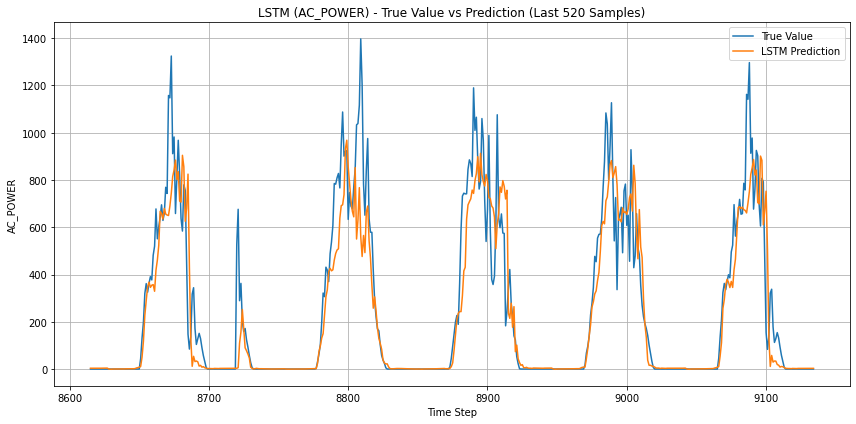

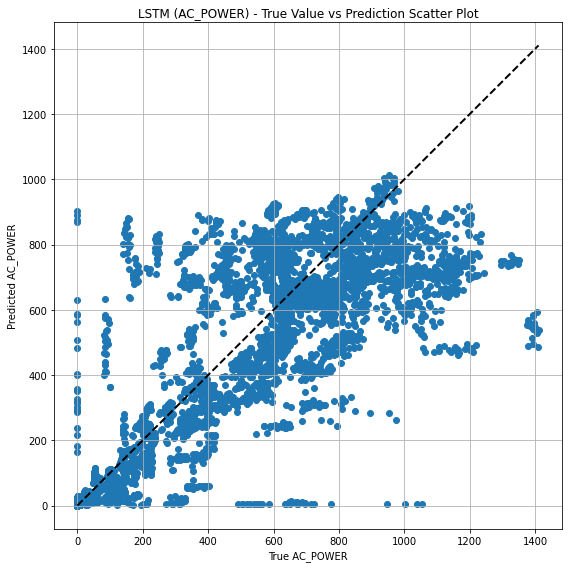

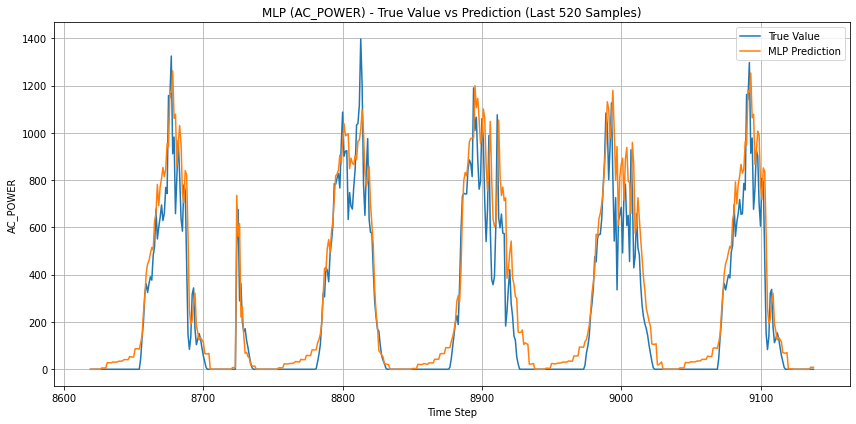

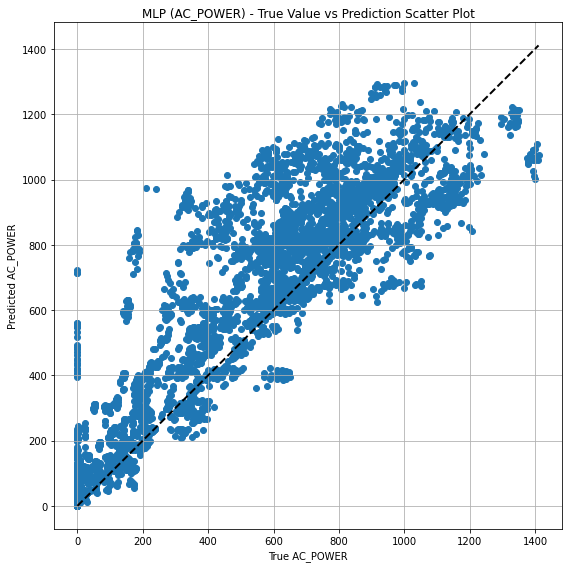

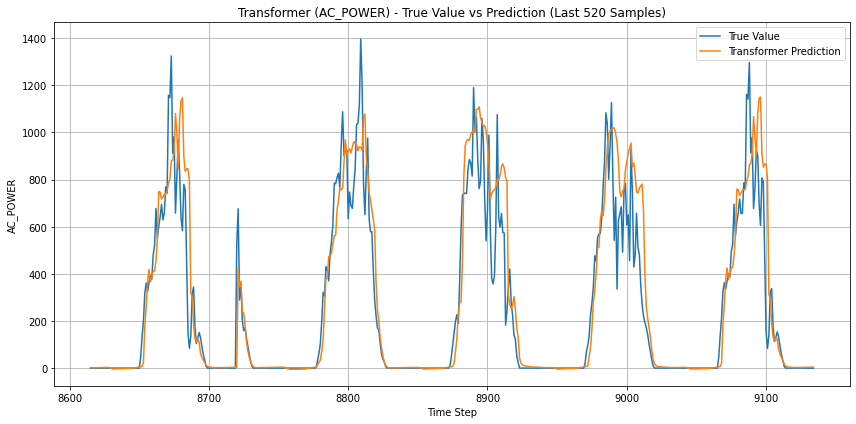

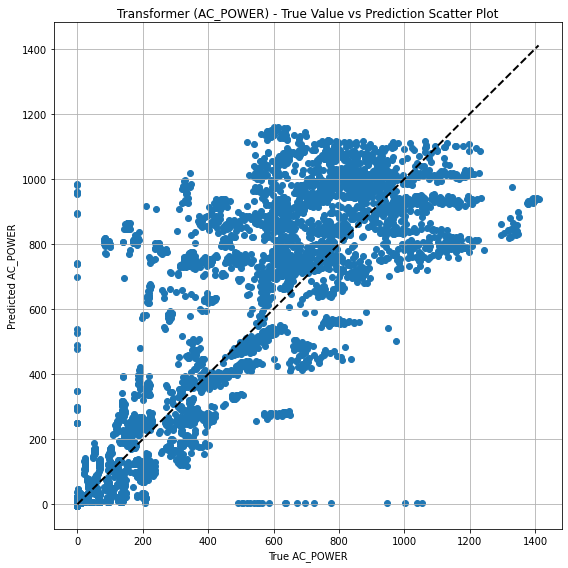

In [15]:
# Transformer Encoder Layer
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1, **kwargs):  # Accept **kwargs
        super(TransformerEncoder, self).__init__(**kwargs)  # Pass kwargs to the superclass
        self.mha = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.rate = rate

    def call(self, inputs, training):
        attn_output = self.mha(inputs, inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

    def get_config(self):
        config = super(TransformerEncoder, self).get_config()
        config.update({
            'embed_dim': self.embed_dim,
            'num_heads': self.num_heads,
            'ff_dim': self.ff_dim,
            'rate': self.rate,
        })
        return config
    
# Load Models
#lstm_model_dc = keras.models.load_model('ECE657_forecast_model/weather_lstm_model_dc.h5')
lstm_model_ac = keras.models.load_model('ECE657_forecast_model/weather_lstm_model_ac.h5')
#mlp_model_dc = keras.models.load_model('ECE657_forecast_model/weather_mlp_model_dc.h5')
mlp_model_ac = keras.models.load_model('ECE657_forecast_model/weather_mlp_model_ac.h5')
#transformer_model_dc = keras.models.load_model('ECE657_forecast_model/weather_transformer_model_dc.h5', custom_objects={'TransformerEncoder': TransformerEncoder})
transformer_model_ac = keras.models.load_model('ECE657_forecast_model/weather_transformer_model_ac.h5', custom_objects={'TransformerEncoder': TransformerEncoder})
transformer_model_ac.summary()

# Assuming your time series data is ready and you need to make predictions for each model
# You might need to adjust X_test based on the input shape of each model

# Redefine the plotting function to accept the target power type
def plot_predictions(y_true, y_pred, model_name, target_power, n_samples=100):
    """
    Plots the time series of true values and predictions with connected points.

    Args:
        y_true (np.ndarray): True label values.
        y_pred (np.ndarray): Model predictions.
        model_name (str): Name of the model for the chart title.
        target_power (str): 'DC_POWER' or 'AC_POWER' for the y-axis label.
        n_samples (int): Number of samples to plot.
    """
    plt.figure(figsize=(12, 6))
    n_total_samples = len(y_true)
    start_index = max(0, n_total_samples - n_samples)
    time_index = np.arange(start_index, n_total_samples)

    plt.plot(time_index, y_true[start_index:], label='True Value')
    plt.plot(time_index, y_pred[start_index:], label=f'{model_name} Prediction')
    plt.title(f'{model_name} ({target_power}) - True Value vs Prediction (Last {n_samples} Samples)')
    plt.xlabel('Time Step')
    plt.ylabel(target_power)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_scatter(y_true, y_pred, model_name, target_power):
    """
    Plots the scatter plot of true values vs predictions.

    Args:
        y_true (np.ndarray): True label values.
        y_pred (np.ndarray): Model predictions.
        model_name (str): Name of the model for the chart title.
        target_power (str): 'DC_POWER' or 'AC_POWER' for the axis labels.
    """
    plt.figure(figsize=(8, 8))
    plt.scatter(y_true, y_pred)
    plt.xlabel(f'True {target_power}')
    plt.ylabel(f'Predicted {target_power}')
    plt.title(f'{model_name} ({target_power}) - True Value vs Prediction Scatter Plot')
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=2) # Plot perfect prediction line
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Assuming your test data is processed to match the input format of each model
# For example, LSTM and Transformer require time series format
# Parameter settings
time_steps = 4

def create_sequences(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X.iloc[i:(i + time_steps)].values)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

# Create time series for DC_POWER
#X_train_seq_lstm_dc, y_train_seq_lstm_dc = create_sequences(X_train_dc_scaled, y_train_dc, time_steps)
#X_test_seq_lstm_dc, y_test_seq_lstm_dc = create_sequences(X_test_dc_scaled, y_test_dc, time_steps)
# Make predictions and plot for DC_POWER models
# LSTM DC
# Assuming X_test_lstm_dc has the appropriate shape for LSTM (e.g., (samples, time_steps, features))
#y_test_pred_lstm_dc = lstm_model_dc.predict(X_test_seq_lstm_dc)
# Assuming y_test_original_scale_dc is the corresponding true value (unscaled)
#plot_predictions(y_test_seq_lstm_dc, y_test_pred_lstm_dc, 'LSTM', 'DC_POWER', n_samples=520)
#plot_scatter(y_test_seq_lstm_dc, y_test_pred_lstm_dc, 'LSTM', 'DC_POWER')

# MLP DC
#y_test_pred_mlp_dc = mlp_model_dc.predict(X_test_dc_scaled) # Assuming X_test_mlp_dc has the appropriate shape for MLP
#y_test_pred_mlp_dc = np.maximum(0, y_test_pred_mlp_dc)
#plot_predictions(y_test_dc, y_test_pred_mlp_dc, 'MLP', 'DC_POWER', n_samples=520)
#plot_scatter(y_test_dc, y_test_pred_mlp_dc, 'MLP', 'DC_POWER')

# Parameter settings
time_steps = 4

# Create time series data
def create_sequences(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X.iloc[i:(i + time_steps)].values)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)
# Create time series for DC_POWER
#X_train_seq_transformer_dc, y_train_seq_transformer_dc = create_sequences(X_train_dc_scaled, y_train_dc, time_steps)
#X_test_seq_transformer_dc, y_test_seq_transformer_dc = create_sequences(X_test_dc_scaled, y_test_dc, time_steps)

# Transformer DC
# Assuming X_test_transformer_dc has the appropriate shape for Transformer (e.g., (samples, time_steps, features))
#y_test_pred_transformer_dc = transformer_model_dc.predict(X_test_seq_transformer_dc)
#plot_predictions(y_test_seq_transformer_dc, y_test_pred_transformer_dc, 'Transformer', 'DC_POWER', n_samples=520)
#plot_scatter(y_test_seq_transformer_dc, y_test_pred_transformer_dc, 'Transformer', 'DC_POWER')

# Make predictions and plot for AC_POWER models
time_steps = 4
X_train_seq_lstm_ac, y_train_seq_lstm_ac = create_sequences(X_train_scaled, y_train_ac, time_steps)
X_test_seq_lstm_ac, y_test_seq_lstm_ac = create_sequences(X_test_scaled, y_test_ac, time_steps)
time_steps = 4
X_train_seq_transformer_ac, y_train_seq_transformer_ac = create_sequences(X_train_scaled, y_train_ac, time_steps)
X_test_seq_transformer_ac, y_test_seq_transformer_ac = create_sequences(X_test_scaled, y_test_ac, time_steps)
# LSTM AC
# Assuming X_test_lstm_ac has the appropriate shape for LSTM
y_test_pred_lstm_ac = lstm_model_ac.predict(X_test_seq_lstm_ac)
# Assuming y_test_original_scale_ac is the corresponding true value
plot_predictions(y_test_seq_lstm_ac, y_test_pred_lstm_ac, 'LSTM', 'AC_POWER', n_samples=520)
plot_scatter(y_test_seq_lstm_ac, y_test_pred_lstm_ac, 'LSTM', 'AC_POWER')

# MLP AC
y_test_pred_mlp_ac = mlp_model_ac.predict(X_test_scaled) # Assuming X_test_mlp_ac has the appropriate shape for MLP
y_test_pred_mlp_ac = np.maximum(0, y_test_pred_mlp_ac)
plot_predictions(y_test_ac, y_test_pred_mlp_ac, 'MLP', 'AC_POWER', n_samples=520)
plot_scatter(y_test_ac, y_test_pred_mlp_ac, 'MLP', 'AC_POWER')

# Transformer AC
# Assuming X_test_transformer_ac has the appropriate shape for Transformer
y_test_pred_transformer_ac = transformer_model_ac.predict(X_test_seq_transformer_ac)
plot_predictions(y_test_seq_transformer_ac, y_test_pred_transformer_ac, 'Transformer', 'AC_POWER', n_samples=520)
plot_scatter(y_test_seq_transformer_ac, y_test_pred_transformer_ac, 'Transformer', 'AC_POWER')

In [16]:
def calculate_r_squared(model, X_test, y_test, scaler=None):
    y_pred = model.predict(X_test)
    if scaler:
        # If the target variable was also scaled, inverse transform it
        y_pred_original = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
        y_test_original = scaler.inverse_transform(y_test.values.reshape(-1, 1)).flatten()
        return r2_score(y_test_original, y_pred_original)
    else:
        return r2_score(y_test, y_pred)

print("\n--- R-squared on the Test Set ---")

# LSTM
#r2_lstm_dc = calculate_r_squared(lstm_model_dc, X_test_seq_lstm_dc, y_test_seq_lstm_dc)
#print(f"LSTM (DC_POWER) R-squared: {r2_lstm_dc:.4f}")

r2_lstm_ac = calculate_r_squared(lstm_model_ac, X_test_seq_lstm_ac, y_test_seq_lstm_ac)
print(f"LSTM (AC_POWER) R-squared: {r2_lstm_ac:.4f}")

# MLP
#r2_mlp_dc = calculate_r_squared(mlp_model_dc, X_test_dc_scaled, y_test_dc)
#print(f"MLP (DC_POWER) R-squared: {r2_mlp_dc:.4f}")

r2_mlp_ac = calculate_r_squared(mlp_model_ac, X_test_scaled, y_test_ac)
print(f"MLP (AC_POWER) R-squared: {r2_mlp_ac:.4f}")

# Transformer
#r2_transformer_dc = calculate_r_squared(transformer_model_dc, X_test_seq_transformer_dc, y_test_seq_transformer_dc)
#print(f"Transformer (DC_POWER) R-squared: {r2_transformer_dc:.4f}")

r2_transformer_ac = calculate_r_squared(transformer_model_ac, X_test_seq_transformer_ac, y_test_seq_transformer_ac)
print(f"Transformer (AC_POWER) R-squared: {r2_transformer_ac:.4f}")


--- 模型在測試集上的 R-squared ---
LSTM (AC_POWER) R-squared: 0.8008
MLP (AC_POWER) R-squared: 0.8433
Transformer (AC_POWER) R-squared: 0.7824



--- 殘差圖 ---


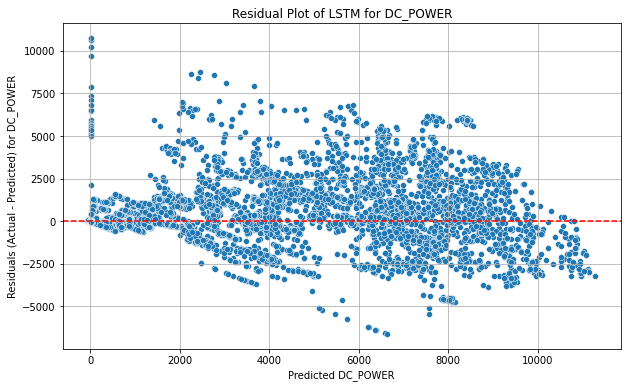

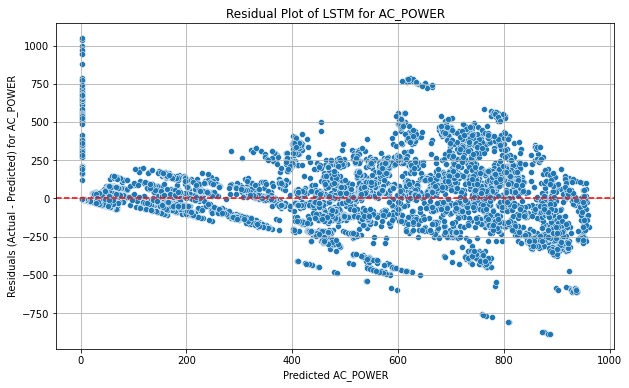

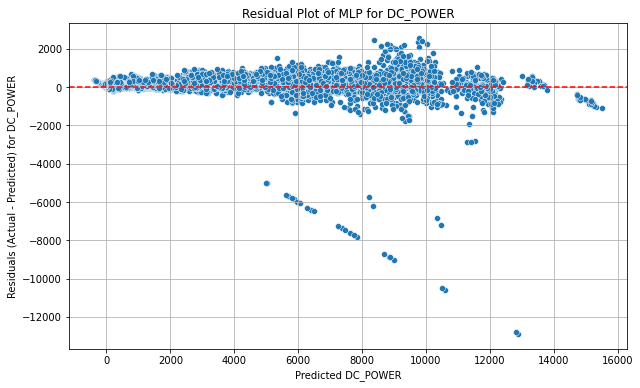

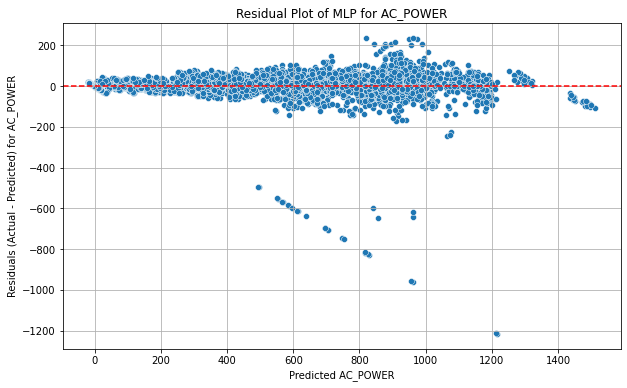

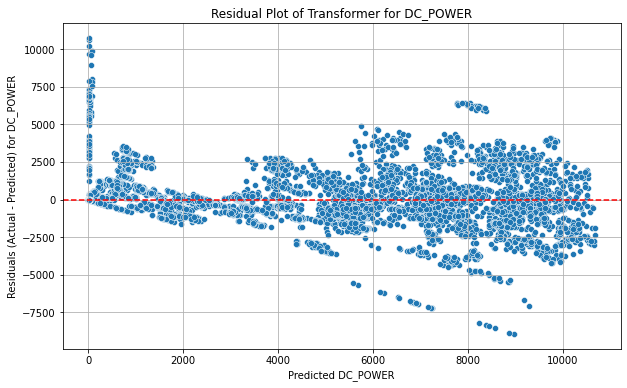

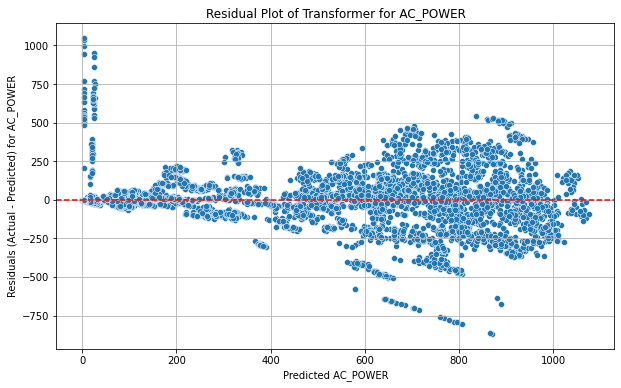

In [21]:
# Okay, here's the code to generate residual plots for your LSTM, MLP, and Transformer models, predicting DC_POWER and AC_POWER respectively.

def plot_residuals(model, X_test, y_test, model_name, target_name, scaler=None):
    """
    Plots the residual plot of the model and handles flattening based on the type of y_test.

    Args:
        model: The trained model.
        X_test: Test set features.
        y_test: Test set true values (can be a NumPy array or Pandas Series).
        model_name: The name of the model (for the chart title).
        target_name: The name of the prediction target (for the chart title).
        scaler: The corresponding scaler if the target variable was scaled.
    """
    y_pred = model.predict(X_test)

    if scaler:
        y_pred_original = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
        y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
        residuals = y_test_original - y_pred_original
    else:
        if isinstance(y_test, pd.Series):
            residuals = y_test.to_numpy().flatten() - y_pred.flatten()
        elif isinstance(y_test, np.ndarray):
            residuals = y_test.flatten() - y_pred.flatten()
        else:
            raise TypeError("y_test must be a NumPy array or Pandas Series")

    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y_pred.flatten(), y=residuals)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel(f'Predicted {target_name}')
    plt.ylabel(f'Residuals (Actual - Predicted) for {target_name}')
    plt.title(f'Residual Plot of {model_name} for {target_name}')
    plt.grid(True)
    plt.show()

print("\n--- Residual Plots ---")

# LSTM (DC_POWER)
# Assuming scaler_dc is the scaler for DC_POWER
# plot_residuals(lstm_model_dc, X_test_seq_lstm_dc, y_test_seq_lstm_dc,
#               "LSTM", "DC_POWER", scaler=scaler_dc)

# LSTM (AC_POWER)
# Assuming scaler_ac is the scaler for AC_POWER
plot_residuals(lstm_model_ac, X_test_seq_lstm_ac, y_test_seq_lstm_ac,
              "LSTM", "AC_POWER")

# MLP (DC_POWER)
# Assuming scaler_dc is the scaler for DC_POWER
# plot_residuals(mlp_model_dc, X_test_dc_scaled, y_test_dc,
#               "MLP", "DC_POWER", scaler=scaler_dc)

# MLP (AC_POWER)
plot_residuals(mlp_model_ac, X_test_ac_scaled, y_test_ac,
              "MLP", "AC_POWER")

# Transformer (DC_POWER)
# Assuming scaler_dc is the scaler for DC_POWER
# plot_residuals(transformer_model_dc, X_test_seq_transformer_dc, y_test_seq_transformer_dc,
#               "Transformer", "DC_POWER", scaler=scaler_dc)

# Transformer (AC_POWER)
plot_residuals(transformer_model_ac, X_test_seq_transformer_ac, y_test_seq_transformer_ac,
              "Transformer", "AC_POWER")